In [1]:
from __future__ import print_function

#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import keras
from keras.models import Sequential, Model, load_model
from keras import backend as K

import tensorflow as tf

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

import os
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
#import seaborn as sns

import urllib
import urllib.request
import pickle
from time import sleep

from scipy.stats import ttest_ind
from scipy.stats import pearsonr, spearmanr

from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize

from interpret_perturb_epistatics_helpers import *


Using TensorFlow backend.


2022-09-01 23:16:02.316951: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2299995000 Hz
2022-09-01 23:16:02.356784: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x559b288b3090 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-01 23:16:02.356841: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-09-01 23:16:02.372939: I tensorflow/core/common_runtime/process_util.cc:136] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:

df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

save_dict = np.load("polyadb_features_pas_3_utr3_perturb.npz")
x, m, l, c, y = save_dict['x'], save_dict['m'], save_dict['l'], save_dict['c'], save_dict['y']

print("x.shape = " + str(x.shape))
print("m.shape = " + str(m.shape))
print("l.shape = " + str(l.shape))
print("c.shape = " + str(c.shape))
print("y.shape = " + str(y.shape))


x.shape = (5267, 10, 205, 4)
m.shape = (5267, 10)
l.shape = (5267, 10)
c.shape = (5267, 10, 28)
y.shape = (5267, 10, 28)


In [ ]:
#Load APARENT Resnet

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5'

save_dir = os.path.join(os.getcwd(), '')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent = load_model(model_path)


In [4]:
#Score all sequences with APARENT (use sum of cuts to capture OR-like logic)

isoform_start = 77
isoform_end = 127

s = np.zeros((x.shape[0], x.shape[1]))
for k in range(x.shape[1]) :
    
    print("Predicting for PAS #" + str(k) + "...")
    
    onehots = x[:, k:k+1, ...]
    
    fake_lib = np.zeros((onehots.shape[0], 13))
    fake_lib[:, 11] = 1.
    
    #Pad
    n_pad = 32 - onehots.shape[0] % 32 if onehots.shape[0] % 32 != 0 else 0

    fake_lib = np.concatenate([fake_lib, np.zeros((n_pad, 13))], axis=0)
    onehots = np.concatenate([onehots, np.zeros((n_pad, 1, 205, 4))], axis=0)
    
    _, pred_cuts = aparent.predict(x=[onehots, fake_lib], batch_size=32, verbose=1)
    
    if n_pad > 0 :
        pred_cuts = pred_cuts[:-n_pad, :]
    
    pred_iso = np.sum(pred_cuts[:, isoform_start:isoform_end], axis=1)
    pred_logit = np.log(pred_iso / (1. - pred_iso))
    
    s[:, k] = pred_logit[:]

s = s * m
s = np.clip(s, -10., 10.)


Predicting for PAS #0...
5280/5280 [==============================] - 9s 2ms/step
Predicting for PAS #1...
5280/5280 [==============================] - 6s 1ms/step
Predicting for PAS #2...
5280/5280 [==============================] - 6s 1ms/step
Predicting for PAS #3...
5280/5280 [==============================] - 6s 1ms/step
Predicting for PAS #4...
5280/5280 [==============================] - 6s 1ms/step
Predicting for PAS #5...
5280/5280 [==============================] - 6s 1ms/step
Predicting for PAS #6...
5280/5280 [==============================] - 6s 1ms/step
Predicting for PAS #7...
5280/5280 [==============================] - 6s 1ms/step
Predicting for PAS #8...
5280/5280 [==============================] - 6s 1ms/step
Predicting for PAS #9...
5280/5280 [==============================] - 6s 1ms/step


In [3]:
#Cache/Load APARENT2 baseline score

#np.save("polyadb_features_pas_3_utr3_perturb_aparent2_all_scores", s)
s = np.load("polyadb_features_pas_3_utr3_perturb_aparent2_all_scores.npy")

print(s.shape)


(5267, 10)


In [4]:

dist_index = np.array([np.nonzero(m[i, :])[0][-1] for i in range(m.shape[0])])

dist_mask = np.zeros(m.shape)
for i in range(m.shape[0]) :
    dist_mask[i, dist_index[i]] = 1.

y_dist = []
for i in range(y.shape[0]) :
    y_dist.append(y[i:i+1, dist_index[i], :])

y_dist = np.concatenate(y_dist, axis=0)

print(y_dist.shape)


(5267, 28)


In [5]:
#Load tissue-specific PAS model and generate scores for select tissue types

subset_cell_types = np.array([
    'NT',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'FIP1L1',
    'NUDT21',
    'RBBP6',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

subset_cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(subset_cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ipykernel import kernelapp as app


In [6]:
#Define tissue-/cell- types

cell_types = np.array([
    'rpm',
    'NT',
    'CDC73',
    'CPSF1',
    'CPSF2',
    'CPSF3',
    'CPSF3L',
    'CPSF4',
    'CPSF6',
    'CSTF1',
    'CSTF3',
    'CTR9',
    'FIP1L1',
    'LEO1',
    'NUDT21',
    'PABPC1',
    'PABPN1',
    'PAF1',
    'PAPOLA',
    'PCF11',
    'RBBP6',
    'RPRD1A',
    'RPRD1B',
    'SCAF8',
    'SF3A1',
    'SRSF3',
    'SYMPK',
    'THOC5'
], dtype=np.object)

cell_type_dict = {
    cell_type : cell_type_i for cell_type_i, cell_type in enumerate(cell_types)
}


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [7]:
#PAS network definition

import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, LocallyConnected2D, MaxPooling2D, GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Conv1D, LocallyConnected1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses

def load_pas_network(n_cell_types=1, n_dil=6, n_channels=32, filter_size=3, filter_size_0=5, nonneg_up_to=0) :
    
    conv_0 = Conv2D(n_channels, kernel_size=(1, filter_size_0), kernel_constraint=keras.constraints.NonNeg() if nonneg_up_to > 0 else None, padding='same', activation='relu', name='pasnet_conv2d_0')
    
    drop_0 = Dropout(0.5, name='pasnet_drop_0')
    
    convs = [
        Conv2D(n_channels, kernel_size=(1, filter_size), kernel_constraint=keras.constraints.NonNeg() if i < nonneg_up_to else None, padding='same', activation='relu', dilation_rate=2**i, name='pasnet_conv2d_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    drops = [
        Dropout(0.5, name='pasnet_drop_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    adds = [
        Lambda(lambda x: x[0] + x[1], name='pasnet_add_' + str(i)) for i in range(1, n_dil+1)
    ]
    
    pool = Lambda(lambda x: K.mean(x, axis=(1, 2)))

    final_dense = Dense(n_cell_types*3, activation='linear', kernel_initializer='zeros', bias_initializer='zeros', name='pasnet_dense_2')
    final_reshape = Lambda(lambda x: K.reshape(x, (K.shape(x)[0], n_cell_types, 3)))
    
    def _net_func(sequence_input) :
        
        x = drop_0(conv_0(sequence_input))

        for i in range(1, n_dil+1):
            x = adds[i-1]([drops[i-1](convs[i-1](x)), x])

        pool_out = pool(x)

        final_dense_out = final_dense(pool_out)
        
        return final_reshape(final_dense_out)

    return _net_func

def _load_pas_model(model_name, n_cell_types=1) :
    
    seq_input = Input(shape=(1, 205, 4), name='seq_input')
    
    pas_net = load_pas_network(n_cell_types=n_cell_types)
    
    pred_output = pas_net(seq_input)
    
    pas_model = Model(seq_input, pred_output)
    pas_model.load_weights(model_name, by_name=True)
    pas_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.SGD(0.1))
    
    return pas_model

def _predict_multi_pas(pas_model, x, batch_size=32) :
    
    y_preds = []
    for k in range(x.shape[1]) :
        y_preds.append(pas_model.predict(x=[x[:, k:k+1, ...]], batch_size=32)[:, None, ...])
    
    return np.concatenate(y_preds, axis=1)


In [7]:
#Model parameters

n_bootstraps = 5
n_cell_types = subset_cell_types.shape[0]


In [9]:
#Predict tissue model scores

tissue_models = [
    _load_pas_model("saved_models/perturb_resnet_utr3_covar_drop_ensemble_" + str(bootstrap_ix) + "_pas_model.h5", n_cell_types=n_cell_types) for bootstrap_ix in range(n_bootstraps)
]
'''
ts_ensemble = np.concatenate([_predict_multi_pas(tissue_models[bootstrap_ix], x, batch_size=32)[..., None] for bootstrap_ix in range(n_bootstraps)], axis=-1)

ts = np.mean(ts_ensemble, axis=-1)

print("ts.shape = " + str(ts.shape))
'''

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


'\nts_ensemble = np.concatenate([_predict_multi_pas(tissue_models[bootstrap_ix], x, batch_size=32)[..., None] for bootstrap_ix in range(n_bootstraps)], axis=-1)\n\nts = np.mean(ts_ensemble, axis=-1)\n\nprint("ts.shape = " + str(ts.shape))\n'

In [8]:
#Cache/Load tissue scores
'''
np.save("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts_ensemble", ts_ensemble)
np.save("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts", ts)
'''
ts_ensemble = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts_ensemble.npy")
ts = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_ts.npy")

print(ts_ensemble.shape)
print(ts.shape)


(5267, 10, 11, 3, 5)
(5267, 10, 11, 3)


In [9]:
#Compute normalization statistics

cell_type_ixs = [cell_type_dict[ct] for ct in subset_cell_types.tolist()]

flat_x = np.reshape(x, (x.shape[0] * x.shape[1], 1, 205, 4))
flat_ts_ensemble = np.reshape(ts_ensemble, (x.shape[0] * x.shape[1], n_cell_types, n_bootstraps, 3))
flat_ts = np.reshape(ts, (x.shape[0] * x.shape[1], n_cell_types, 3))
flat_y = np.reshape(y[:, :, cell_type_ixs], (x.shape[0] * x.shape[1], n_cell_types))
flat_gene_ind = np.reshape(np.tile(np.arange(x.shape[0])[:, None], (1, x.shape[1])), (x.shape[0] * x.shape[1],))
flat_pas_ind = np.reshape(np.tile(np.arange(x.shape[1])[None, :], (x.shape[0], 1)), (x.shape[0] * x.shape[1],))

flat_m = np.reshape(m, (x.shape[0] * x.shape[1],))
flat_dist_mask = np.reshape(dist_mask, (x.shape[0] * x.shape[1],))

flat_keep_index = np.nonzero(flat_m >= 1)[0]

flat_x = flat_x[flat_keep_index, ...]
flat_ts_ensemble = flat_ts_ensemble[flat_keep_index, ...]
flat_ts = flat_ts[flat_keep_index, ...]
flat_y = flat_y[flat_keep_index, ...]
flat_gene_ind = flat_gene_ind[flat_keep_index, ...]
flat_pas_ind = flat_pas_ind[flat_keep_index, ...]

flat_m = flat_m[flat_keep_index, ...]
flat_dist_mask = flat_dist_mask[flat_keep_index, ...]


In [10]:
#Construct masks for proximal/middle/distal sites

flat_prox_mask = np.array((flat_pas_ind == 0), dtype=np.float32)
flat_middle_mask = 1. - flat_dist_mask - flat_prox_mask

flat_masks = [
    flat_prox_mask,
    flat_middle_mask,
    flat_dist_mask
]


In [11]:
#Load processed (flattened) PAS IDs from original dataframe

flat_ids = np.load("polyadb_features_pas_3_utr3_perturb_flat_ids.npy", allow_pickle=True)

#Compile and flatten gene names
flat_gene_names = []
for _, row in df.iterrows() :
    flat_gene_names.extend([row['gene'] for k in range(m.shape[1]) if row['pas_exists_' + str(k)] == 1])

flat_gene_names = np.array(flat_gene_names, dtype=object)


In [12]:
#Re-load gated importance scores

flat_scores = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_flat_g_scores.npy")
flat_scores = np.tile(flat_scores, (1, 1, 1, 1, 1, 4)) * flat_x[None, None, ...]

print("flat_scores.shape = " + str(flat_scores.shape))

#Re-load gated importance scores (bootstrap replicates)

n_bootstraps = 3

flat_scores_ensemble = []

for bootstrap_ix in range(n_bootstraps) :
    flat_scores_curr = np.load("polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_flat_g_scores_bootstrap_" + str(bootstrap_ix) + ".npy")
    flat_scores_curr = np.tile(flat_scores_curr, (1, 1, 1, 1, 1, 4)) * flat_x[None, None, ...]
    
    flat_scores_ensemble.append(flat_scores_curr)
    
    print("(bootstrap_ix = " + str(bootstrap_ix) + ") flat_scores.shape = " + str(flat_scores_curr.shape))


flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 0) flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 1) flat_scores.shape = (11, 3, 14764, 1, 205, 4)
(bootstrap_ix = 2) flat_scores.shape = (11, 3, 14764, 1, 205, 4)


In [13]:
#Get flat representation of sequences as dataframe

seqs = flat_x[:, 0, ...]

seqs_str = []
for i in range(seqs.shape[0]) :
    seq = ""
    for j in range(seqs.shape[1]) :
        if seqs[i, j, 0] == 1. :
            seq += "A"
        elif seqs[i, j, 1] == 1. :
            seq += "C"
        elif seqs[i, j, 2] == 1. :
            seq += "G"
        elif seqs[i, j, 3] == 1. :
            seq += "T"
    
    seqs_str.append(seq)

seqs_str = np.array(seqs_str, dtype=np.object)

df = pd.DataFrame({
    "seq" : seqs_str.tolist(),
})

print("len(df) = " + str(len(df)))


len(df) = 14764


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


--- cell_type_2 = 'NUDT21' ---
NUDT21_pwm_0_fwd
0.042685610221308165
0.8506891503053553


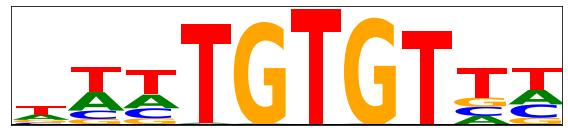

----------
NUDT21_pwm_1_fwd
0.16534737642112585
0.9294057541792092


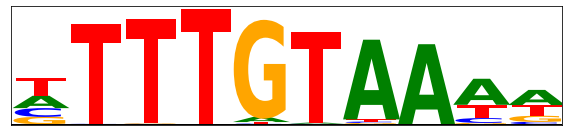

----------
NUDT21_pwm_2_fwd
0.0720766422631857
0.912656715588692


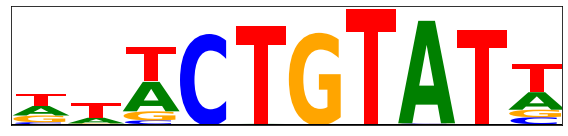

----------
NUDT21_pwm_3_fwd
0.20631838203606445
0.8966035753347298


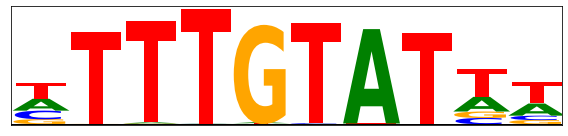

----------
NUDT21_pwm_4_fwd
0.018261191461767454
0.8037952280774409


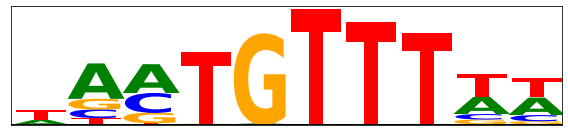

----------
NUDT21_pwm_5_fwd
-1.1682650210939616e-05
0.815986765584638


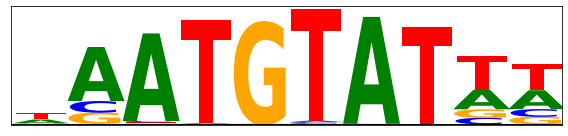

----------
NUDT21_pwm_6_fwd
0.20659450541387447
0.7534644860226113


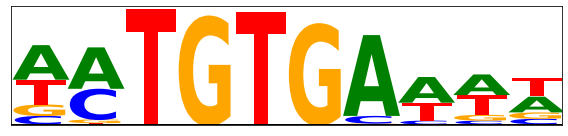

----------
NUDT21_pwm_7_fwd
0.17419561194286282
0.7234382584351282


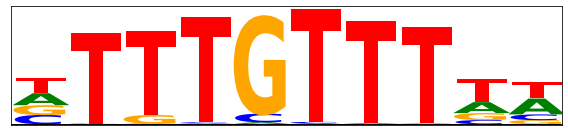

----------
NUDT21_pwm_8_fwd
0.041648255234144824
0.7510004138629698


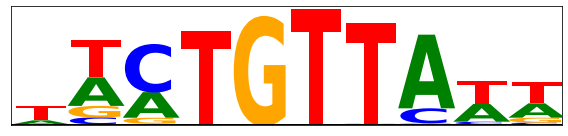

----------
NUDT21_pwm_9_fwd
0.12008685202434147
0.7208340114560621


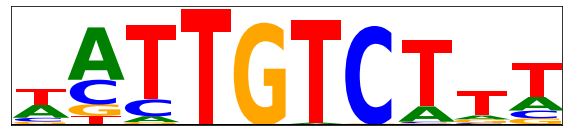

----------
NUDT21_pwm_10_fwd
0.1972596716700178
0.8995976557334264


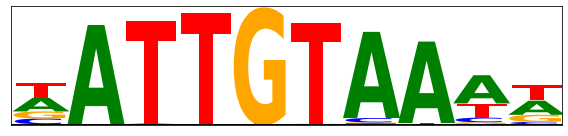

----------
NUDT21_pwm_11_fwd
0.10138721563776985
0.8509733772668683


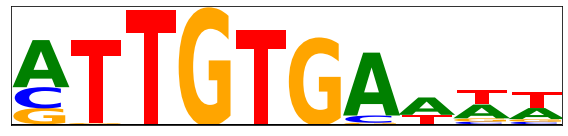

----------
NUDT21_pwm_12_fwd
0.07204392809590858
0.7846636426152035


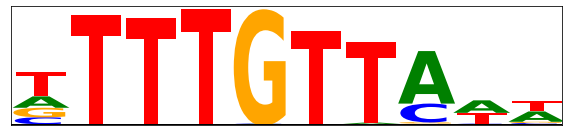

----------
NUDT21_pwm_13_fwd
0.27328587126224596
0.6187370945544953


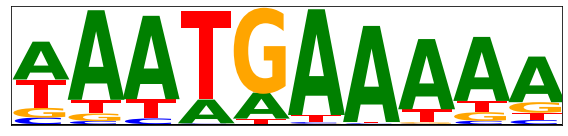

----------
NUDT21_pwm_14_fwd
0.20487122599854063
0.8502811346353437


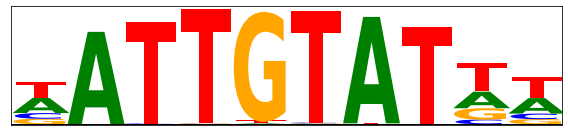

----------
NUDT21_pwm_15_fwd
0.05402772738554766
0.7958111511212644


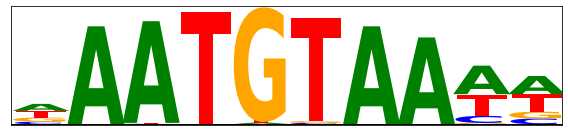

----------
NUDT21_pwm_16_fwd
0.08605463285491152
0.8372860973736025


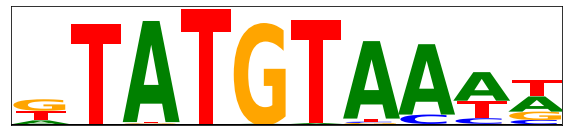

----------
NUDT21_pwm_17_fwd
0.15448027792159447
0.9529135572282892


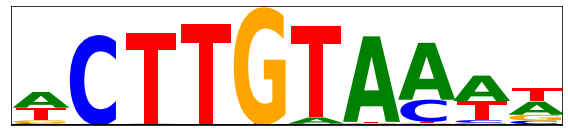

----------
NUDT21_pwm_18_fwd
-0.04080223041830711
0.8382204798818792


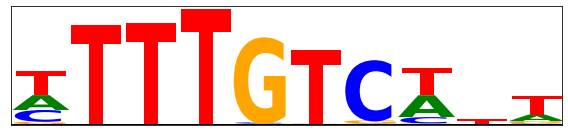

----------
NUDT21_pwm_19_fwd
0.1317541551350349
0.8211743028918702


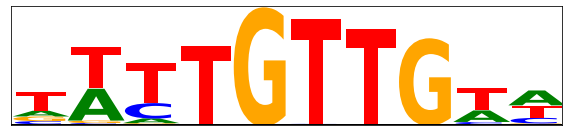

----------
NUDT21_pwm_20_fwd
0.10209649838702216
0.9304996625291115


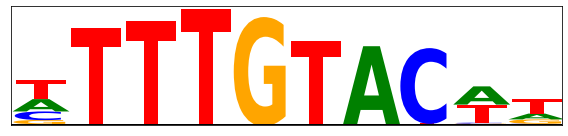

----------
NUDT21_pwm_21_fwd
0.12391288660942237
0.9142726743474919


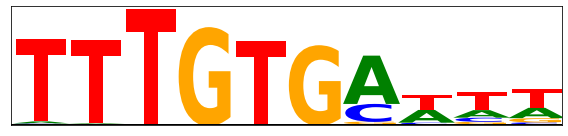

----------
NUDT21_pwm_22_fwd
0.12870762627175514
0.8810394084199946


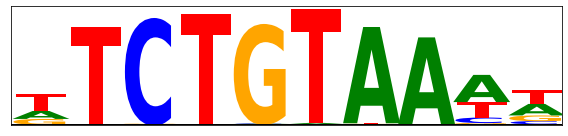

----------
NUDT21_pwm_23_fwd
0.18803325987631275
0.9112996915335296


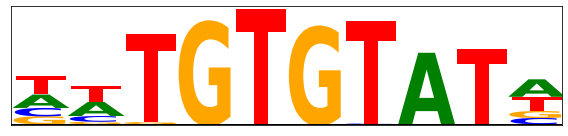

----------
NUDT21_pwm_24_fwd
0.1676652136813389
0.7347445380821657


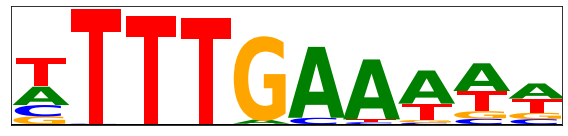

----------
NUDT21_pwm_25_fwd
0.1315999071738299
0.7546038930556354


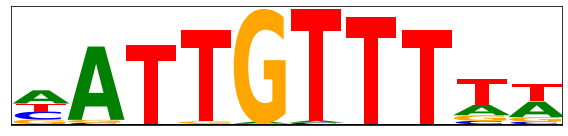

----------
NUDT21_pwm_26_fwd
0.09475999963497686
0.8358261642341842


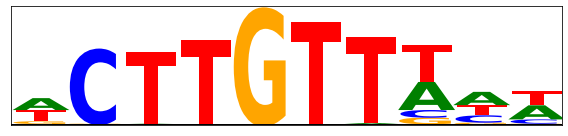

----------
NUDT21_pwm_27_fwd
0.22779087438905168
0.9945548313892693


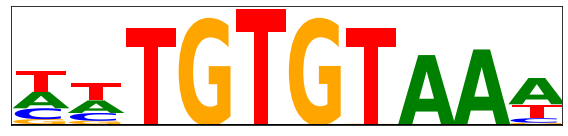

----------
NUDT21_pwm_28_fwd
0.1340273843952483
0.7250195267741665


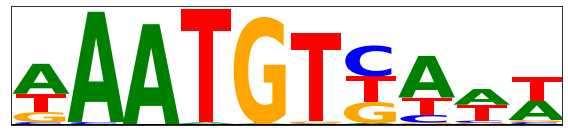

----------
NUDT21_pwm_29_fwd
0.07196259101231893
0.8062113899451036


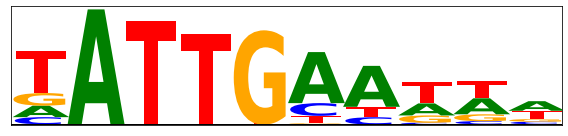

----------
NUDT21_pwm_30_fwd
-0.008774261600923865
0.7599603008750259


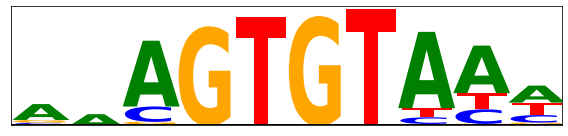

----------
NUDT21_pwm_31_fwd
0.07005269304911294
0.7601427211761475


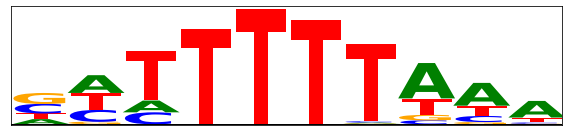

----------
NUDT21_pwm_32_fwd
0.13628501441027666
0.9022583806836928


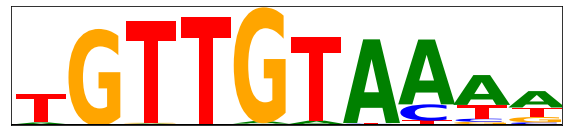

----------
NUDT21_pwm_33_fwd
0.04571738159739887
0.8364720381223238


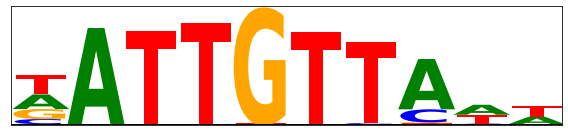

----------
NUDT21_pwm_34_fwd
0.10471959449875522
0.811335359492772


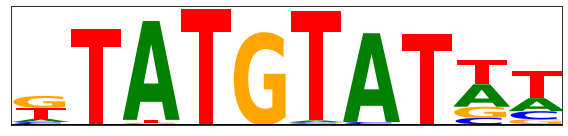

----------
NUDT21_pwm_35_fwd
0.10933822359837274
0.8867171133068246


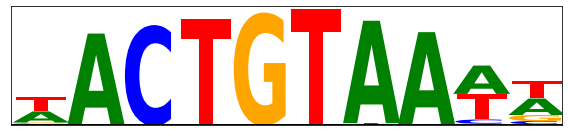

----------
NUDT21_pwm_36_fwd
0.08638193049329394
0.8004875101941696


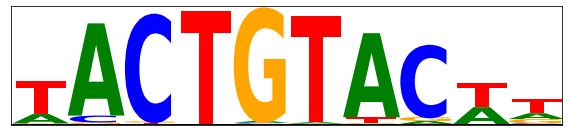

----------
NUDT21_pwm_37_fwd
-0.1250390244953668
0.7975121704500112


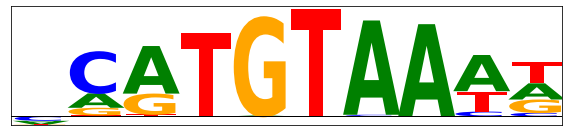

----------
NUDT21_pwm_38_fwd
0.08546433332489757
0.8695393275439254


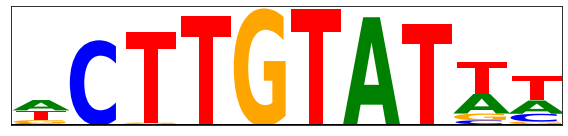

----------
NUDT21_pwm_39_fwd
0.04466773641520533
0.8142146209190633


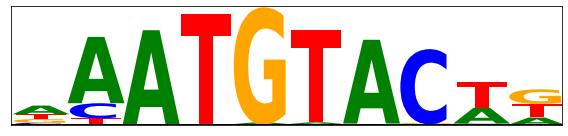

----------
NUDT21_pwm_40_fwd
0.06546209900124561
0.9639455515204124


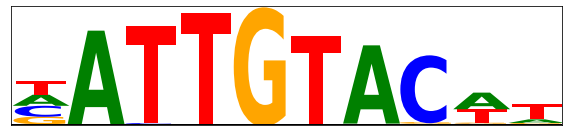

----------
NUDT21_pwm_41_fwd
-0.09391259050369263
0.8027857646942139


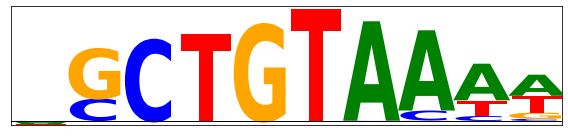

----------
NUDT21_pwm_42_fwd
0.13422702464860736
0.8772016584258719


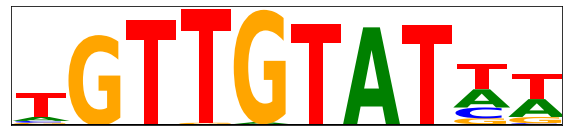

----------
NUDT21_pwm_43_fwd
0.1274117436519889
0.8460470953653025


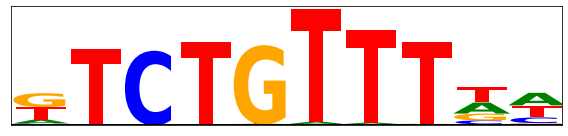

----------
NUDT21_pwm_44_fwd
0.03381155610084534
0.8100534629821777


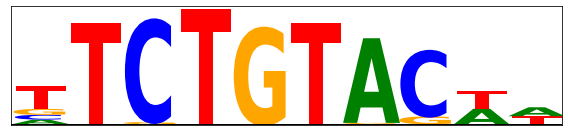

----------
NUDT21_pwm_45_fwd
0.11286524920850187
0.727752837619266


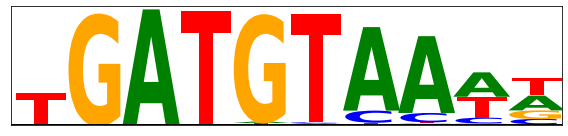

----------
NUDT21_pwm_46_fwd
0.018659858181052008
0.7255802298245365


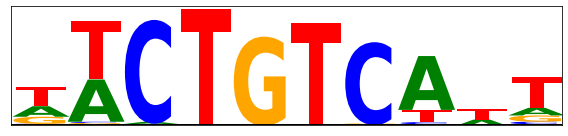

----------
NUDT21_pwm_47_fwd
0.14106216870821442
0.7945899259127103


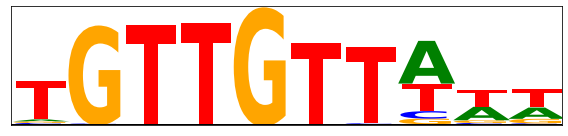

----------
NUDT21_pwm_48_fwd
-0.04741312776293074
0.7541570493153164


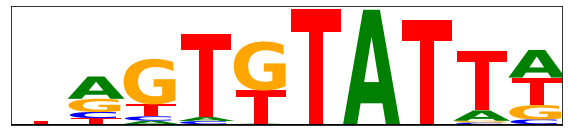

----------
NUDT21_pwm_49_fwd
-0.16306135429526275
0.8430433597204819


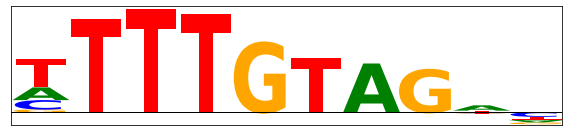

----------
NUDT21_pwm_50_fwd
-0.11913486171413111
0.8670569342535894


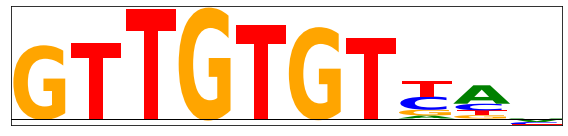

----------
--- cell_type_2 = 'CSTF3' ---
CSTF3_pwm_0_fwd
-0.00942058910032828
0.6264448110201805


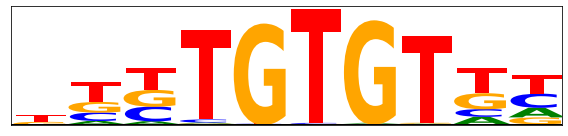

----------
CSTF3_pwm_1_fwd
0.047332711268992175
0.5480411866368764


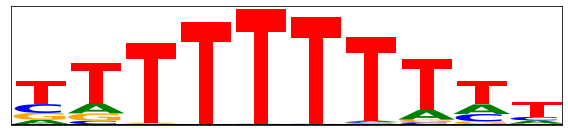

----------
CSTF3_pwm_2_fwd
0.09273639518507037
0.5761865556578105


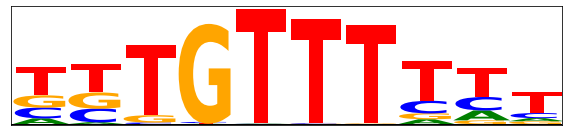

----------
CSTF3_pwm_3_fwd
0.023306302043132422
0.5898753046510047


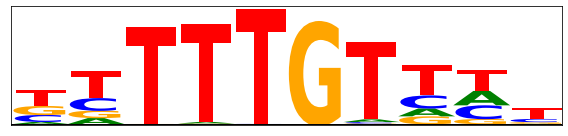

----------
CSTF3_pwm_4_fwd
0.11621185855773111
0.5173157384262824


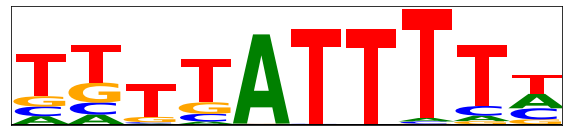

----------
CSTF3_pwm_5_fwd
0.024339427947998038
0.5623812274543607


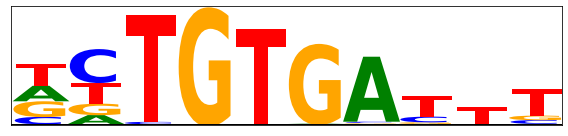

----------
CSTF3_pwm_6_fwd
0.24722441128924885
0.581988933656068


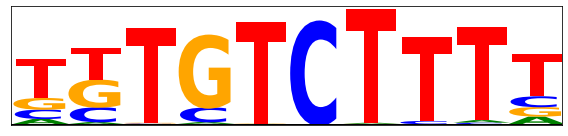

----------
CSTF3_pwm_7_fwd
0.04012798852327337
0.5323763596384149


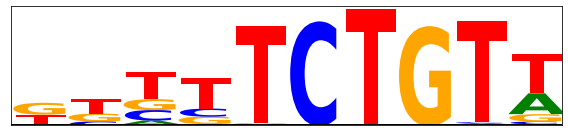

----------
CSTF3_pwm_8_fwd
0.0001009127943988053
0.5412100943966188


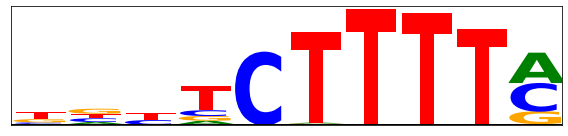

----------
CSTF3_pwm_9_fwd
0.07791184694339068
0.5171844086280236


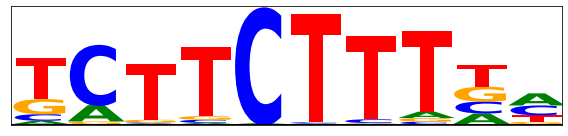

----------
CSTF3_pwm_10_fwd
0.042483028192170626
0.5065187354362448


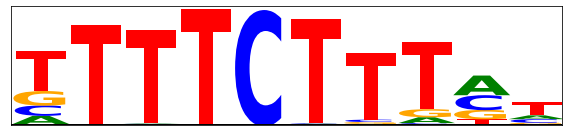

----------
CSTF3_pwm_11_fwd
0.13998520246116064
0.5090463802378665


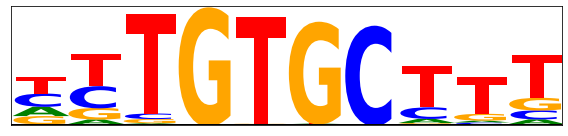

----------
CSTF3_pwm_12_fwd
0.070468285408887
0.6010147571563721


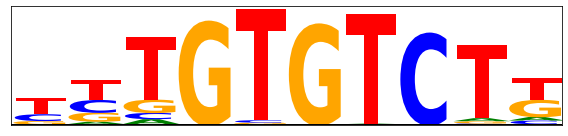

----------
CSTF3_pwm_13_fwd
0.10963301289151285
0.5373627316184908


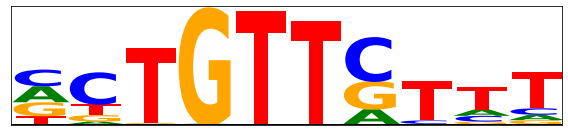

----------
CSTF3_pwm_14_fwd
0.18671699230160033
0.5804966989017668


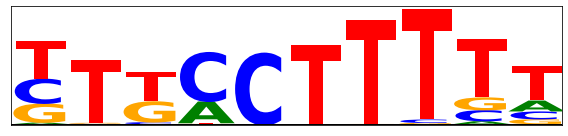

----------
CSTF3_pwm_15_fwd
0.004320633628151625
0.6069252904256185


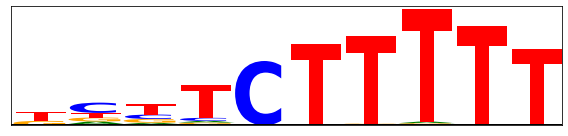

----------
CSTF3_pwm_16_fwd
0.2050706318446568
0.47886507851736887


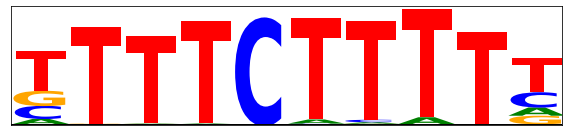

----------
CSTF3_pwm_17_fwd
-0.026425715855189734
0.5724684647151402


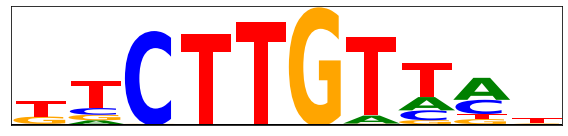

----------
CSTF3_pwm_18_fwd
-0.027180398523417956
0.5620595850975685


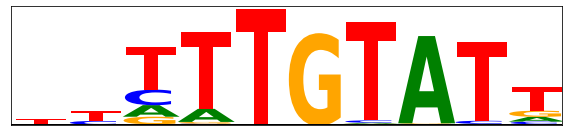

----------
CSTF3_pwm_19_fwd
0.127290980231683
0.4535191719105702


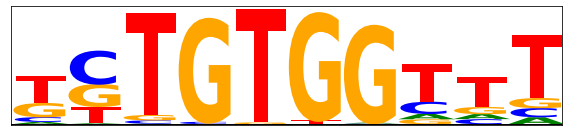

----------
CSTF3_pwm_20_fwd
0.07915621284780831
0.5139092212298821


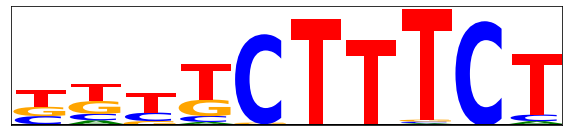

----------
CSTF3_pwm_21_fwd
0.12473797223863808
0.5273574656813684


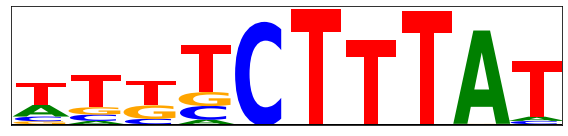

----------
CSTF3_pwm_22_fwd
-0.011581570144713393
0.5358789295662106


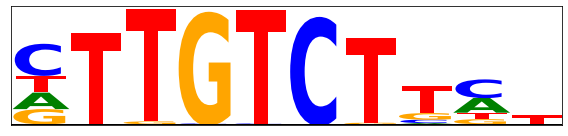

----------
CSTF3_pwm_23_fwd
-0.036063672139726846
0.5055878409023943


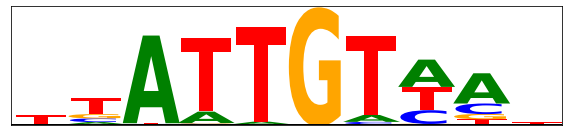

----------
CSTF3_pwm_24_fwd
0.022516283781632125
0.5038142494533373


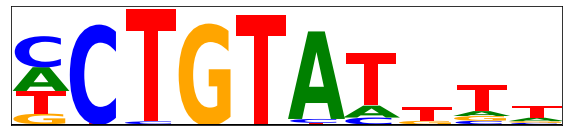

----------
CSTF3_pwm_25_fwd
-0.008924081789708778
0.5447499556879026


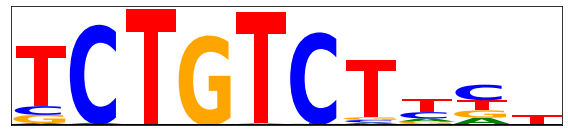

----------
CSTF3_pwm_26_fwd
0.09776568911292335
0.5681849288940429


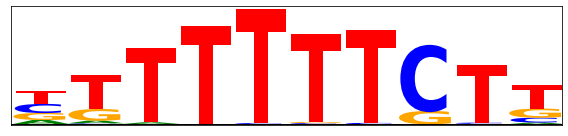

----------
CSTF3_pwm_27_fwd
0.2227208161572797
0.5459936446006145


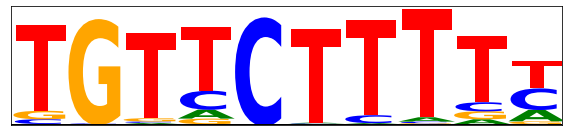

----------
CSTF3_pwm_28_fwd
0.1445968324892989
0.5522337432219604


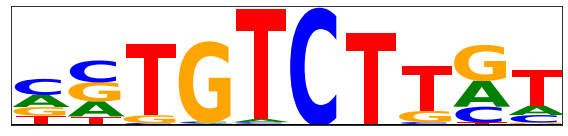

----------
CSTF3_pwm_29_fwd
0.21425045266443368
0.5184961095148203


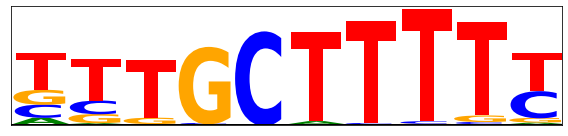

----------
CSTF3_pwm_30_fwd
0.023175036388894774
0.49018181510593584


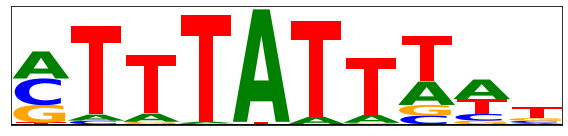

----------
CSTF3_pwm_31_fwd
0.04101691216230393
0.5096874269843101


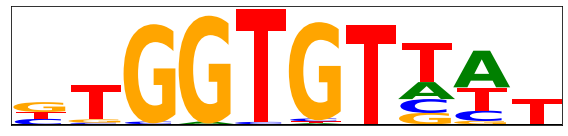

----------
CSTF3_pwm_32_fwd
0.12508249521255493
0.5880914664268493


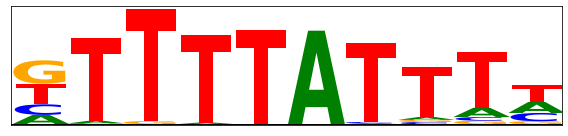

----------
CSTF3_pwm_33_fwd
0.19281449019908906
0.553003354707072


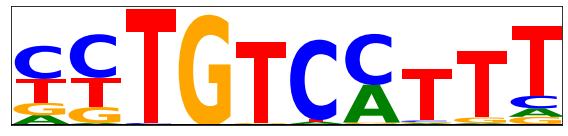

----------
CSTF3_pwm_34_fwd
0.20001403407046672
0.6589874685856334


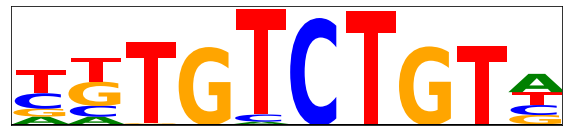

----------
CSTF3_pwm_35_fwd
0.08007566840560348
0.5236783575128626


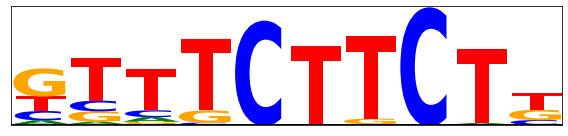

----------
CSTF3_pwm_36_fwd
0.012240764072963164
0.6031096867152623


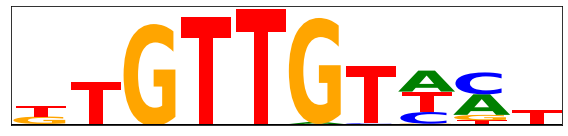

----------
CSTF3_pwm_37_fwd
0.16922173208119917
0.5544493928247568


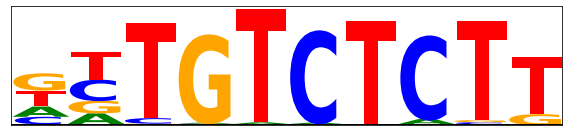

----------
--- cell_type_2 = 'RBBP6' ---
RBBP6_pwm_0_fwd
0.08131378263122913
0.19835130473601173


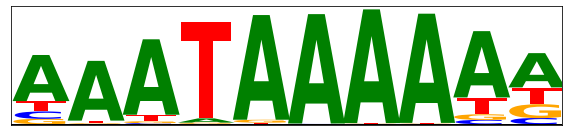

----------
RBBP6_pwm_1_fwd
0.02101620319977547
0.2215556935199256


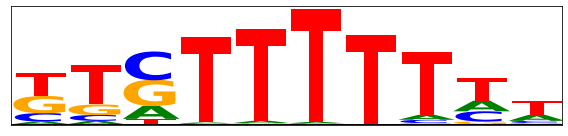

----------
RBBP6_pwm_2_fwd
0.10431467056274416
0.27332090377807616


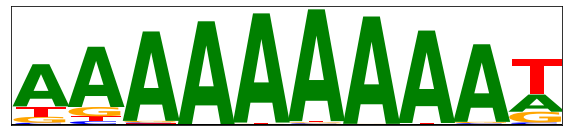

----------
RBBP6_pwm_3_fwd
0.10463260823808362
0.2051504754654282


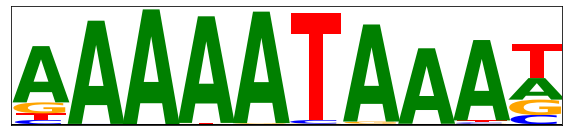

----------
RBBP6_pwm_4_fwd
0.11808344328303855
0.2100669267117811


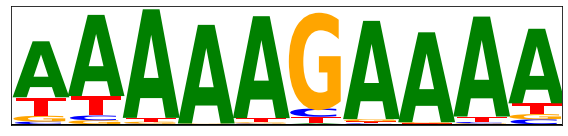

----------
RBBP6_pwm_5_fwd
0.041453406588329175
0.21650495501370887


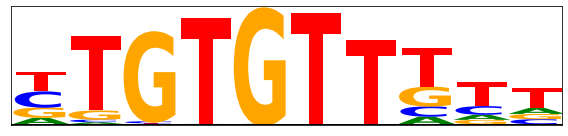

----------
RBBP6_pwm_6_fwd
0.0528378327221465
0.23845860881190148


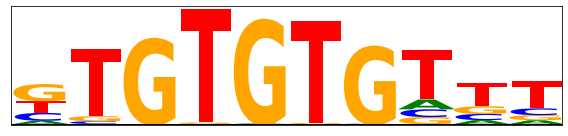

----------
RBBP6_pwm_7_fwd
0.08323360717933598
0.1830506579566548


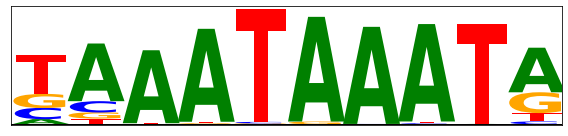

----------
RBBP6_pwm_8_fwd
0.012556805647195985
0.20787727677502393


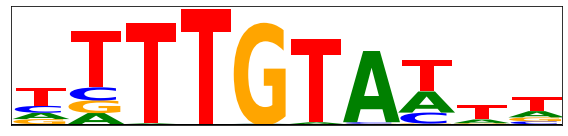

----------
RBBP6_pwm_9_fwd
0.04056911873541284
0.20640164526272925


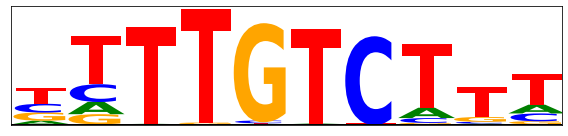

----------
RBBP6_pwm_10_fwd
0.06448424303973163
0.20414167863351326


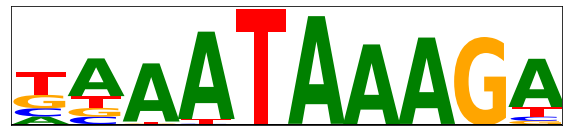

----------
RBBP6_pwm_11_fwd
0.049121490710882974
0.185604006384835


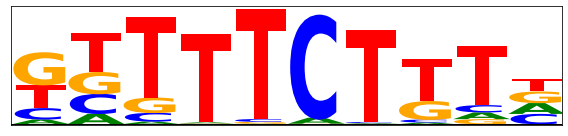

----------
RBBP6_pwm_12_fwd
0.03363684619811767
0.2078439151539522


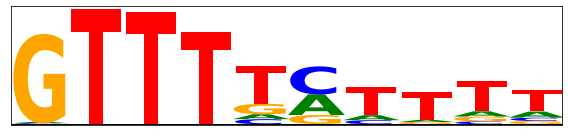

----------
RBBP6_pwm_13_fwd
0.023187346954566205
0.19500757118180997


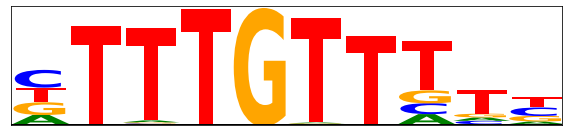

----------
RBBP6_pwm_14_fwd
0.05362903905469317
0.2040961831115013


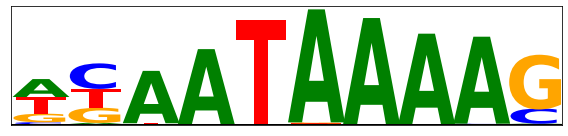

----------
RBBP6_pwm_15_fwd
0.060226983683449885
0.19202139718191963


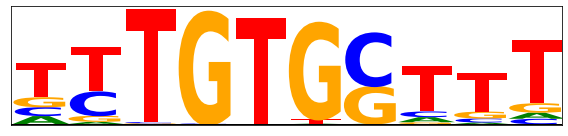

----------
RBBP6_pwm_16_fwd
0.04533318712667454
0.23065058234279143


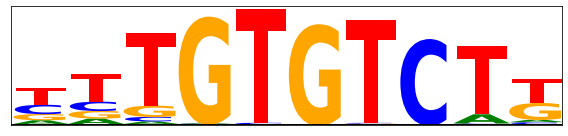

----------
RBBP6_pwm_17_fwd
0.024740632075183788
0.19864010600923745


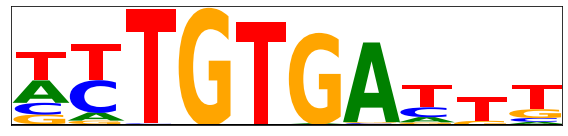

----------
RBBP6_pwm_18_fwd
-0.019855700174967447
0.22650976562500003


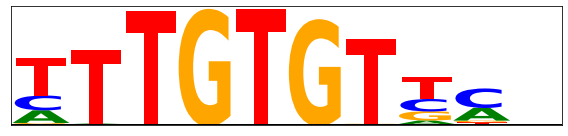

----------
RBBP6_pwm_19_fwd
-0.018259501295024842
0.20530801760096126


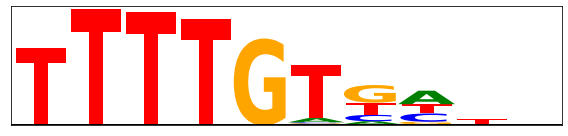

----------
RBBP6_pwm_20_fwd
0.019551368498466382
0.2137354891065141


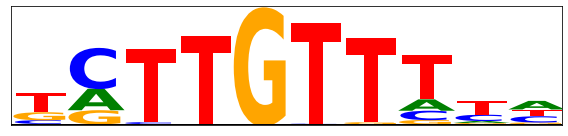

----------
RBBP6_pwm_21_fwd
0.0031116832386363577
0.18419922192891441


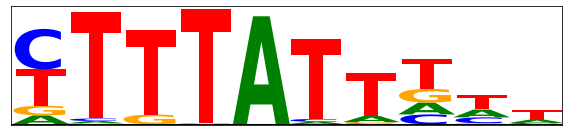

----------
RBBP6_pwm_22_fwd
0.014479748285733743
0.2247875037560096


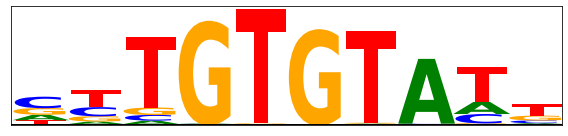

----------
RBBP6_pwm_23_fwd
0.00513141786950266
0.1890670234321529


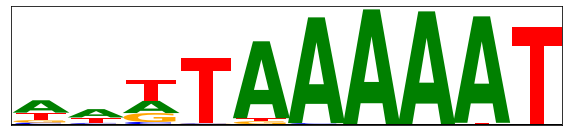

----------
RBBP6_pwm_24_fwd
-0.010908690328183385
0.24386984120244565


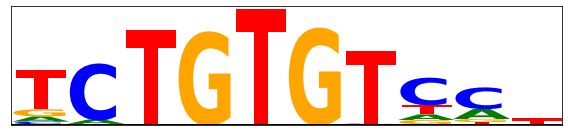

----------
RBBP6_pwm_25_fwd
0.05922410384468411
0.2011616914168648


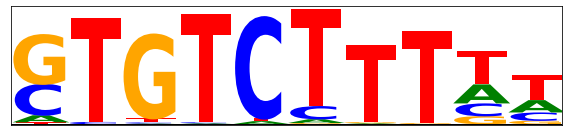

----------
RBBP6_pwm_26_fwd
0.037755670962126356
0.20586993673573367


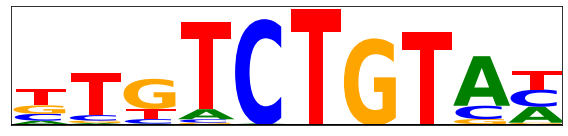

----------
RBBP6_pwm_27_fwd
0.04879092645207676
0.2081261871057913


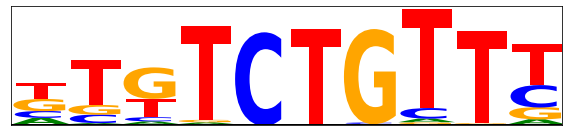

----------
RBBP6_pwm_28_fwd
0.020179210844494047
0.20270635695684525


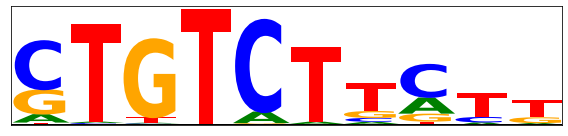

----------
RBBP6_pwm_29_fwd
0.0010558976067437074
0.20309244791666664


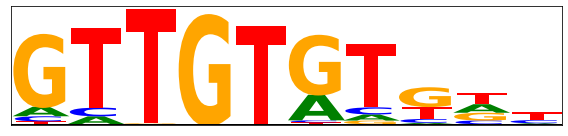

----------
RBBP6_pwm_30_fwd
-0.005807402761358967
0.22516861765008223


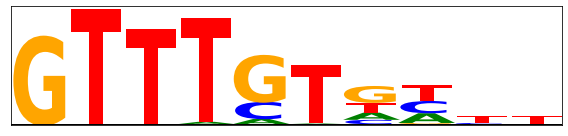

----------
RBBP6_pwm_31_fwd
0.048783725119651636
0.1837582659214101


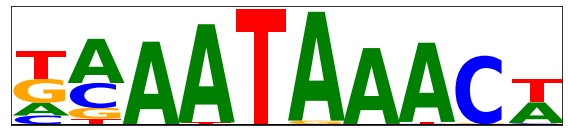

----------
RBBP6_pwm_32_fwd
-0.019772630327203302
0.2094361637415511


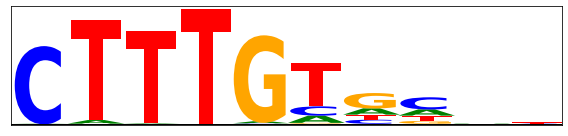

----------
RBBP6_pwm_33_fwd
0.018656693776448564
0.18451999537150066


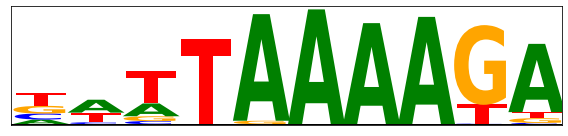

----------
RBBP6_pwm_34_fwd
0.08257043226709906
0.19909529775943396


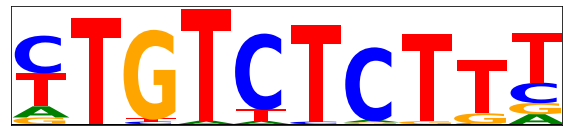

----------
RBBP6_pwm_35_fwd
0.0684854962609031
0.18716230392456054


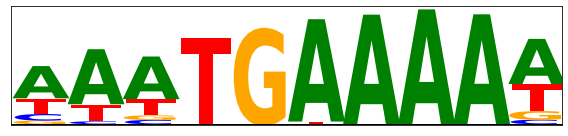

----------
RBBP6_pwm_36_fwd
0.04513620775799419
0.1731709325036337


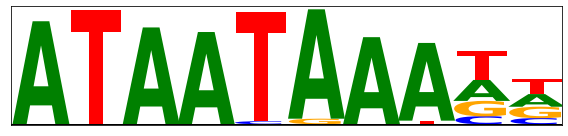

----------
RBBP6_pwm_37_fwd
0.05026918411254884
0.20788482666015623


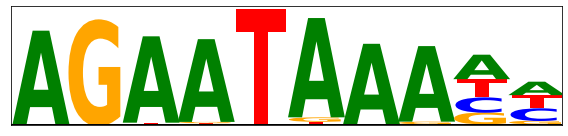

----------
RBBP6_pwm_38_fwd
0.07798924301609848
0.20394694010416664


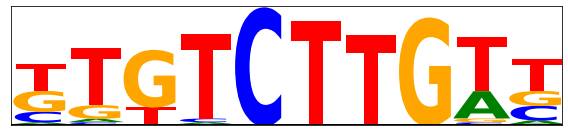

----------


In [14]:
#NUDT21, CSTF3 and RBBP6 UGUA vs. GUGU (and AWUAAA) analysis

import h5py

#Load NUDT21 modisco PWMs

seq_start = 0
seq_end = 205

cell_type_1_ix = 0
cell_type_2_index = [6, 4, 7]

modisco_suffixes = ['', '', '_neg']

score_ix = 2

modisco_fs = [h5py.File('polyadb_features_pas_3_utr3_perturb_resnet_covar_drop_seq_start_' + str(seq_start) + '_seq_end_' + str(seq_end) + '_tfmodisco_out_cell_type_ix_1_' + str(cell_type_1_ix) + '_cell_type_ix_2_' + str(cell_type_2_ix) + '_score_ix_' + str(score_ix) + '_no_rc' + modisco_suffixes[modisco_i] + '.h5', 'r') for modisco_i, cell_type_2_ix in enumerate(cell_type_2_index)]

all_pwms = [[] for _ in range(len(cell_type_2_index))]
all_contribs = [[] for _ in range(len(cell_type_2_index))]
all_hypo_contribs = [[] for _ in range(len(cell_type_2_index))]

pwm_names = [[] for _ in range(len(cell_type_2_index))]

for modisco_i, cell_type_2_ix in enumerate(cell_type_2_index) :

    print("--- cell_type_2 = '" + str(subset_cell_types[cell_type_2_ix]) + "' ---")
    
    fwd_pwms = []
    fwd_contribs = []
    fwd_hypo_contribs = []

    patterns = modisco_fs[modisco_i]['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']

    for i in range(len(patterns) - 1) :
        fwd_pwms.append(patterns["pattern_" + str(i)]["sequence"]["fwd"][()])
        fwd_contribs.append(patterns["pattern_" + str(i)]["task_contrib_scores"]["fwd"][()])
        fwd_hypo_contribs.append(patterns["pattern_" + str(i)]["task_hypothetical_contribs"]["fwd"][()])

    for i in range(len(patterns) - 1) :
        all_pwms[modisco_i].append(fwd_pwms[i])
        all_contribs[modisco_i].append(fwd_contribs[i])
        all_hypo_contribs[modisco_i].append(fwd_hypo_contribs[i])

        pwm_names[modisco_i].append(str(subset_cell_types[cell_type_2_ix]) + "_pwm_" + str(i) + "_fwd")

    #Plot PWMs
    for i in range(len(all_pwms[modisco_i])) :
        print(pwm_names[modisco_i][i])

        plot_pwm_2(all_contribs[modisco_i][i], figsize=(8, 2), plot_y_ticks=False)

        print("----------")


In [15]:
#Analysis 1: Homotypic TGTA motif combinations

#Find all TGTA motif hits in NUDT21

modisco_i = 0

pattern_index = [1, 2, 3, 5, 10, 14, 15, 16, 17, 20, 22, 23, 27, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 49]

pattern_width = 10

seq_start = 0
seq_end = 146

cell_type_1_ix = 0
cell_type_2_ix = 6

all_pwm_matches = []
all_pwm_match_poses = []

modisco_f = modisco_fs[modisco_i]

for pattern_ix in pattern_index :

    pwm_match_l = modisco_f['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']["pattern_" + str(pattern_ix)]["seqlets_and_alnmts"]["seqlets"][()]#.keys()

    pwm_matches = [int(str(s).split("example:")[1].split(",")[0]) for s in pwm_match_l.tolist() if "rc:" in str(s)]
    pwm_match_poses = [int(str(s).split("start:")[1].split(",")[0]) for s in pwm_match_l.tolist() if "rc:" in str(s)]
    
    #print(len(pwm_matches))
    
    all_pwm_matches.extend(pwm_matches)
    all_pwm_match_poses.extend(pwm_match_poses)

pwm_matches = np.unique(all_pwm_matches).tolist()
not_pwm_matches = [i for i in np.arange(flat_ts.shape[0]).tolist() if i not in set(pwm_matches)]

pwm_match_index = all_pwm_matches
pwm_match_poses = all_pwm_match_poses

pwm_null_index = np.random.choice(not_pwm_matches, size=(len(pwm_match_index),), replace=True).tolist()
null_matches = np.unique(pwm_null_index).tolist()

print(len(pwm_matches))
print(len(not_pwm_matches))

#Construct mask to extract select motif hits from importance scores
pwm_match_mask = np.zeros((flat_scores.shape[2], flat_scores.shape[4], flat_scores.shape[5]))
pwm_null_mask = np.zeros((flat_scores.shape[2], flat_scores.shape[4], flat_scores.shape[5]))

for pwm_match_ix, pwm_match_pos in zip(pwm_match_index, pwm_match_poses) :
    
    pwm_match_mask[pwm_match_ix, pwm_match_pos:pwm_match_pos+pattern_width, :] = 1.

for pwm_match_ix, pwm_match_pos in zip(pwm_null_index, pwm_match_poses) :
    
    pwm_null_mask[pwm_match_ix, pwm_match_pos:pwm_match_pos+pattern_width, :] = 1.


4583
10181


s_abl_both - s_ref (median) = 1.5236
s_abl_1 - s_ref (median) = 0.3801
s_abl_2 - s_ref (median) = 0.8676


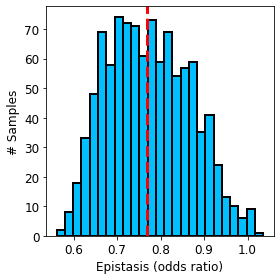

Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
epi_scores.shape = (345,)
epi_scores_null.shape = (345,)
wilcoxon p = 3.8414737700764235e-45


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


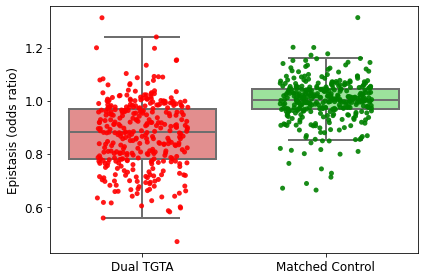

In [28]:
#Analyze epistatic interaction (Homotypic TGTA, single example)

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_NUDT21_dual_TGTA'

#Single example
_analyze_epistatics(i=189, n_samples=1024, cell_type_1_ix=0, cell_type_2_ix=6, score_ix=2, region_1=[[2, 2+5]], region_2=[[20, 20+5], [48, 48+5]], save_figs=save_figs, fig_name=fig_name)

#All motif hits
subset_index = np.nonzero((np.sum(pwm_match_mask[:, 70:76, 0], axis=-1) == 0.) & ((np.sum(pwm_match_mask[..., 0], axis=-1) >= 20. - 1.) & (np.sum(pwm_match_mask[..., 0], axis=-1) <= 20. + 1.)))[0].tolist()
_valid_null_pos_func = lambda start_1, start_2, pattern_width: [j for j in range(70 - pattern_width) if (j <= start_1 - pattern_width) or (j >= start_1 + pattern_width and j <= start_2 - pattern_width) or (j >= start_2 + pattern_width)]

_analyze_epistatics_many(subset_index, pwm_match_mask, pwm_match_index, pwm_match_poses, cell_type_1_ix=0, cell_type_2_ix=6, score_ix=2, n_samples=32, _valid_null_pos_func=_valid_null_pos_func, hypo_str="Dual TGTA", save_figs=save_figs, fig_name=fig_name)


In [40]:
#Find sequences without wildtype TGTA motifs (multiple compositions tested)

n_wt = 64

df['n_tgta'] = df['seq'].str.slice(0, 70).str.count("TGTA")
df['cano_cse'] = df['seq'].str.slice(70, 76).str.contains("AATAAA|ATTAAA|AGTAAA|TATAAA|GATAAA|CATAAA")
df['use_cse'] = df['seq'].str.slice(0, 70).str.contains("AATAAA|ATTAAA")

df['A'] = df['seq'].str.slice(0, 70).str.count("A") / 70.
df['C'] = df['seq'].str.slice(0, 70).str.count("C") / 70.
df['G'] = df['seq'].str.slice(0, 70).str.count("G") / 70.
df['T'] = df['seq'].str.slice(0, 70).str.count("T") / 70.

df['gc_composition'] = (df['G'] + df['C'] >= 0.50) & (df['T'] <= 0.15)
df['at_composition'] = (df['A'] + df['T'] >= 0.70) & (df['G'] <= 0.10)

gc_wt_index = np.nonzero((((df['n_tgta'] == 0) & (df['cano_cse'] == 1)) & ((df['gc_composition'] == True) & (df['use_cse'] == 0))).values)[0][:n_wt]
at_wt_index = np.nonzero((((df['n_tgta'] == 0) & (df['cano_cse'] == 1)) & ((df['at_composition'] == True) & (df['use_cse'] == 0))).values)[0][:n_wt]

seqs_wt_gc = df.iloc[gc_wt_index]['seq'].values.tolist()
seqs_wt_at = df.iloc[at_wt_index]['seq'].values.tolist()

print("len(seqs_wt_gc) = " + str(len(seqs_wt_gc)))
print("len(seqs_wt_at) = " + str(len(seqs_wt_at)))

sim_seqs = [
    seqs_wt_gc,
    seqs_wt_gc,
    seqs_wt_gc,
    seqs_wt_at,
    seqs_wt_at,
    seqs_wt_at,
]

sim_motifs = [
    ["TTGTAT", "TTGTAT"],
    ["TGTA", "TGTA"],
    ["ATTGTA", "TGTAAT"],
    ["TTGTAT", "TTGTAT"],
    ["TGTA", "TGTA"],
    ["ATTGTA", "TGTAAT"],
]

sim_pos_funcs = [
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
]

sim_names = [
    "(wt) G+C > 50%",
    "(wt) G+C > 50%",
    "(wt) G+C > 50%",
    "(wt) A+T > 70%",
    "(wt) A+T > 70%",
    "(wt) A+T > 70%",
]

#Construct synthetic upstream backgrounds with specified GC/AT content

cse_and_dse = "AATAAATTTATTTTTGATGGCAACAAAATTGAAACACTTATTTAAGAAAAACAGAGATTGAGGTGGTTTTGAAGTAAAAGTGTCATATTTTGGATTCTAAAATGGAGTCAATATACAAAATATACTACTTTGATA"

sim_seqs = sim_seqs + [
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.2, 0.4, 0.4, 0.0], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.3, 0.3, 0.3, 0.1], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.25, 0.25, 0.25, 0.25], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.3, 0.3, 0.1, 0.3], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.4, 0.2, 0.0, 0.4], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.2, 0.4, 0.4, 0.0], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.3, 0.3, 0.3, 0.1], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.25, 0.25, 0.25, 0.25], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.3, 0.3, 0.1, 0.3], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.4, 0.2, 0.0, 0.4], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.2, 0.4, 0.4, 0.0], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.3, 0.3, 0.3, 0.1], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.25, 0.25, 0.25, 0.25], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.3, 0.3, 0.1, 0.3], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
    ["".join(np.random.choice(['A', 'C', 'G', 'T'], p=[0.4, 0.2, 0.0, 0.4], size=(70,)).tolist()) + cse_and_dse for _ in range(n_wt)],
]

sim_motifs = sim_motifs + [
    ["TTGTAT", "TTGTAT"],
    ["TTGTAT", "TTGTAT"],
    ["TTGTAT", "TTGTAT"],
    ["TTGTAT", "TTGTAT"],
    ["TTGTAT", "TTGTAT"],
    
    ["TGTA", "TGTA"],
    ["TGTA", "TGTA"],
    ["TGTA", "TGTA"],
    ["TGTA", "TGTA"],
    ["TGTA", "TGTA"],
    
    ["ATTGTA", "TGTAAT"],
    ["ATTGTA", "TGTAAT"],
    ["ATTGTA", "TGTAAT"],
    ["ATTGTA", "TGTAAT"],
    ["ATTGTA", "TGTAAT"],
]

sim_pos_funcs = sim_pos_funcs + [
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
    [lambda motif_1_len: np.arange(70-motif_1_len).tolist(), lambda motif_2_len: np.arange(70-motif_2_len).tolist()],
]

sim_names = sim_names + [
    "(syn) G+C = 80%",
    "(syn) G+C = 60%",
    "(syn) G+C = 50%",
    "(syn) A+T = 60%",
    "(syn) A+T = 80%",
    
    "(syn) G+C = 80%",
    "(syn) G+C = 60%",
    "(syn) G+C = 50%",
    "(syn) A+T = 60%",
    "(syn) A+T = 80%",
    
    "(syn) G+C = 80%",
    "(syn) G+C = 60%",
    "(syn) G+C = 50%",
    "(syn) A+T = 60%",
    "(syn) A+T = 80%",
]


len(seqs_wt_gc) = 64
len(seqs_wt_at) = 64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


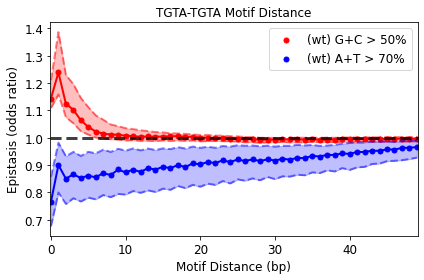

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


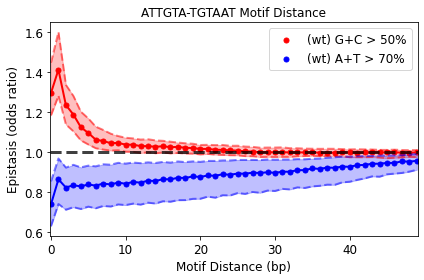

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


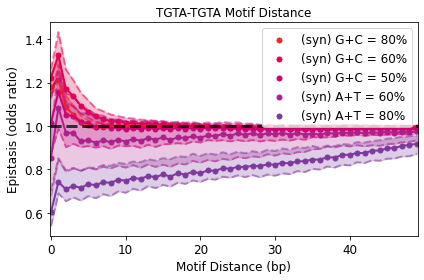

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


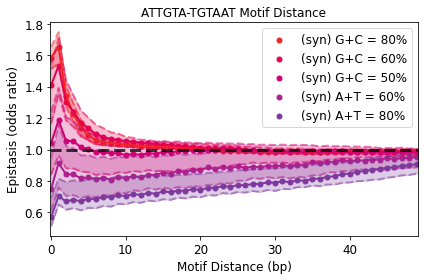

In [41]:
#Dual TGTA motif analysis: WT compositions and synthetic compositions

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_NUDT21_dual_TGTA'

load_from_cache = True
cache_name = 'apa_perturb_covar_dual_tgta_insertion_epi_scores'

hypo_names = [
    #"TTGTAT-TTGTAT Motif Distance",
    "TGTA-TGTA Motif Distance",
    "ATTGTA-TGTAAT Motif Distance",
    #"TTGTAT-TTGTAT Motif Distance",
    "TGTA-TGTA Motif Distance",
    "ATTGTA-TGTAAT Motif Distance",
]

sim_indexes = [
    #[0, 3],
    [1, 4],
    [2, 5],
    #[6, 7, 8, 9, 10],
    [11, 12, 13, 14, 15],
    [16, 17, 18, 19, 20],
]

sim_color_maps = [
    #['red', 'blue'],
    ['red', 'blue'],
    ['red', 'blue'],
    #['#ee2626', '#e70050', '#d00073', '#ad208e', '#7e399e'],
    ['#ee2626', '#e70050', '#d00073', '#ad208e', '#7e399e'],
    ['#ee2626', '#e70050', '#d00073', '#ad208e', '#7e399e'],
]

x_ranges = [
    #[0, 50],
    [0, 50],
    [0, 50],
    #[0, 50],
    [0, 50],
    [0, 50],
]

plot_areas = [
    #True,
    True,
    True,
    #True,
    True,
    True,
]

fig_names = [
    #fig_name + "_wt_TTGTAT_TTGTAT",
    fig_name + "_wt_TGTA_TGTA",
    fig_name + "_wt_ATTGTA_TGTAAT",
    #fig_name + "_syn_TTGTAT_TTGTAT",
    fig_name + "_syn_TGTA_TGTA",
    fig_name + "_syn_ATTGTA_TGTAAT",
]

_run_insertional_motif_simulation(sim_seqs, sim_motifs, sim_pos_funcs, sim_names, cell_type_1_ix=0, cell_type_2_ix=6, score_ix=2, load_from_cache=load_from_cache, cache_name=cache_name, hypo_names=hypo_names, sim_indexes=sim_indexes, sim_color_maps=sim_color_maps, x_ranges=x_ranges, plot_areas=plot_areas, fig_names=fig_names, save_figs=save_figs)


In [42]:
#Find sequences without wildtype TGTA motifs (multiple compositions tested; nucleotide-shuffled)

def _scramble_sequence(seq, start, end) :
    
    seq_index = np.arange(len(seq), dtype=np.int32)
    
    np.random.shuffle(seq_index[start:end])
    
    new_seq = ""
    for j in range(len(seq)) :
        new_seq += seq[seq_index[j]]
    
    return new_seq

n_wt = 64

df['n_tgta'] = df['seq'].str.slice(0, 70).str.count("TGTA")
df['cano_cse'] = df['seq'].str.slice(70, 76).str.contains("AATAAA|ATTAAA|AGTAAA|TATAAA|GATAAA|CATAAA")
df['use_cse'] = df['seq'].str.slice(0, 70).str.contains("AATAAA|ATTAAA")

df['A'] = df['seq'].str.slice(0, 70).str.count("A") / 70.
df['C'] = df['seq'].str.slice(0, 70).str.count("C") / 70.
df['G'] = df['seq'].str.slice(0, 70).str.count("G") / 70.
df['T'] = df['seq'].str.slice(0, 70).str.count("T") / 70.

df['gc_composition'] = (df['G'] + df['C'] >= 0.50) & (df['T'] <= 0.15)
df['at_composition'] = (df['A'] + df['T'] >= 0.70) & (df['G'] <= 0.10)

wt_index = np.nonzero((((df['n_tgta'] == 0) & (df['cano_cse'] == 1)) & (df['use_cse'] == 0)).values)[0][:n_wt]
gc_wt_index = np.nonzero((((df['n_tgta'] == 0) & (df['cano_cse'] == 1)) & ((df['gc_composition'] == True) & (df['use_cse'] == 0))).values)[0][:n_wt]
at_wt_index = np.nonzero((((df['n_tgta'] == 0) & (df['cano_cse'] == 1)) & ((df['at_composition'] == True) & (df['use_cse'] == 0))).values)[0][:n_wt]

seqs_wt = df.iloc[wt_index]['seq'].values.tolist()
seqs_wt_gc = df.iloc[gc_wt_index]['seq'].values.tolist()
seqs_wt_at = df.iloc[at_wt_index]['seq'].values.tolist()

print("len(seqs_wt) = " + str(len(seqs_wt)))
print("len(seqs_wt_gc) = " + str(len(seqs_wt_gc)))
print("len(seqs_wt_at) = " + str(len(seqs_wt_at)))

sim_seqs = [
    seqs_wt,
    seqs_wt,
    seqs_wt,
    [_scramble_sequence(seqs_wt[wt_ix], 0, 70) for wt_ix in range(len(seqs_wt))],
    [_scramble_sequence(seqs_wt[wt_ix], 0, 70) for wt_ix in range(len(seqs_wt))],
    [_scramble_sequence(seqs_wt[wt_ix], 0, 70) for wt_ix in range(len(seqs_wt))],
    [_scramble_sequence(seqs_wt_gc[wt_ix], 0, 70) for wt_ix in range(len(seqs_wt_gc))],
    [_scramble_sequence(seqs_wt_gc[wt_ix], 0, 70) for wt_ix in range(len(seqs_wt_gc))],
    [_scramble_sequence(seqs_wt_gc[wt_ix], 0, 70) for wt_ix in range(len(seqs_wt_gc))],
    [_scramble_sequence(seqs_wt_at[wt_ix], 0, 70) for wt_ix in range(len(seqs_wt_at))],
    [_scramble_sequence(seqs_wt_at[wt_ix], 0, 70) for wt_ix in range(len(seqs_wt_at))],
    [_scramble_sequence(seqs_wt_at[wt_ix], 0, 70) for wt_ix in range(len(seqs_wt_at))],
]

sim_motifs = [
    ["TTGTAT", "TTGTAT"],
    ["TGTA", "TGTA"],
    ["ATTGTA", "TGTAAT"],
    ["TTGTAT", "TTGTAT"],
    ["TGTA", "TGTA"],
    ["ATTGTA", "TGTAAT"],
    ["TTGTAT", "TTGTAT"],
    ["TGTA", "TGTA"],
    ["ATTGTA", "TGTAAT"],
    ["TTGTAT", "TTGTAT"],
    ["TGTA", "TGTA"],
    ["ATTGTA", "TGTAAT"],
]

sim_names = [
    "(wt) sample",
    "(wt) sample",
    "(wt) sample",
    "(wt) scrambled",
    "(wt) scrambled",
    "(wt) scrambled",
    "(wt) s G+C > 50%",
    "(wt) s G+C > 50%",
    "(wt) s G+C > 50%",
    "(wt) s A+T > 70%",
    "(wt) s A+T > 70%",
    "(wt) s A+T > 70%",
]


len(seqs_wt) = 64
len(seqs_wt_gc) = 64
len(seqs_wt_at) = 64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


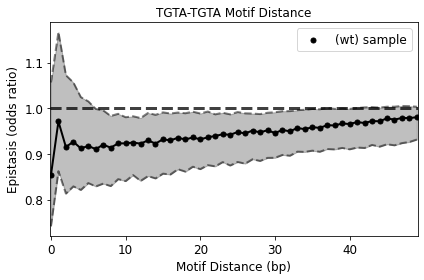

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


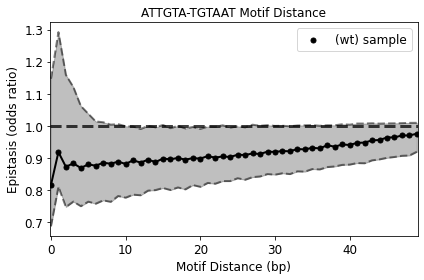

In [43]:
#Dual TGTA motif analysis: uniform WT sample

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_NUDT21_dual_TGTA'

load_from_cache = True
cache_name = 'apa_perturb_covar_dual_tgta_insertion_2_epi_scores'

hypo_names = [
    #"TTGTAT-TTGTAT Motif Distance",
    "TGTA-TGTA Motif Distance",
    "ATTGTA-TGTAAT Motif Distance",
]

sim_indexes = [
    #[0],
    [1],
    [2],
]

sim_color_maps = [
    #['black'],
    ['black'],
    ['black'],
]

x_ranges = [
    #[0, 50],
    [0, 50],
    [0, 50],
]

plot_areas = [
    #True,
    True,
    True,
]

fig_names = [
    #fig_name + "_unif_wt_TTGTAT_TTGTAT",
    fig_name + "_unif_wt_TGTA_TGTA",
    fig_name + "_unif_wt_ATTGTA_TGTAAT",
]

_run_insertional_motif_simulation(sim_seqs, sim_motifs, sim_pos_funcs, sim_names, cell_type_1_ix=0, cell_type_2_ix=6, score_ix=2, load_from_cache=load_from_cache, cache_name=cache_name, hypo_names=hypo_names, sim_indexes=sim_indexes, sim_color_maps=sim_color_maps, x_ranges=x_ranges, plot_areas=plot_areas, fig_names=fig_names, save_figs=save_figs)


In [44]:
#Find sequences without wildtype TGTA motifs (varying flank compositions)

n_wt = 64

df['n_tgta'] = df['seq'].str.slice(0, 70).str.count("TGTA")
df['cano_cse'] = df['seq'].str.slice(70, 76).str.contains("AATAAA|ATTAAA|AGTAAA|TATAAA|GATAAA|CATAAA")
df['use_cse'] = df['seq'].str.slice(0, 70).str.contains("AATAAA|ATTAAA")

df['A'] = df['seq'].str.slice(0, 70).str.count("A") / 70.
df['C'] = df['seq'].str.slice(0, 70).str.count("C") / 70.
df['G'] = df['seq'].str.slice(0, 70).str.count("G") / 70.
df['T'] = df['seq'].str.slice(0, 70).str.count("T") / 70.

wt_index = np.nonzero((((df['n_tgta'] == 0) & (df['cano_cse'] == 1)) & (df['use_cse'] == 0)).values)[0][:n_wt]

seqs_wt = df.iloc[wt_index]['seq'].values.tolist()

print("len(seqs_wt) = " + str(len(seqs_wt)))

sim_seqs = [
    seqs_wt,
    seqs_wt,
    seqs_wt,
    seqs_wt,
    seqs_wt,
    seqs_wt,
    seqs_wt,
    seqs_wt,
]

sim_motifs = [
    ["TTTTGTATTT", "TTTTGTATTT"],
    ["GGGTGTAGGG", "GGGTGTAGGG"],
    ["TTTTGTATT", "TTTGTATTT"],
    ["GGGTGTAGG", "GGTGTAGGG"],
    ["TTTTGTAT", "TTGTATTT"],
    ["GGGTGTAG", "GTGTAGGG"],
    ["TTTTGTA", "TGTATTT"],
    ["GGGTGTA", "TGTAGGG"],
]

sim_names = [
    "(wt) TTTTGTATTT-TTTTGTATTT",
    "(wt) GGGTGTAGGG-GGGTGTAGGG",
    "(wt) TTTTGTATT-TTTGTATTT",
    "(wt) GGGTGTAGG-GGTGTAGGG",
    "(wt) TTTTGTAT-TTGTATTT",
    "(wt) GGGTGTAG-GTGTAGGG",
    "(wt) TTTTGTA-TGTATTT",
    "(wt) GGGTGTA-TGTAGGG",
]


len(seqs_wt) = 64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


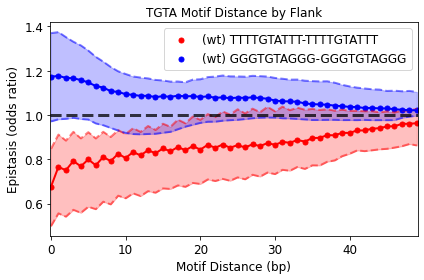

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


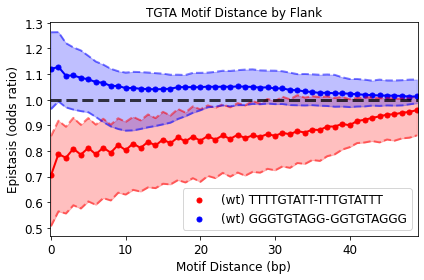

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


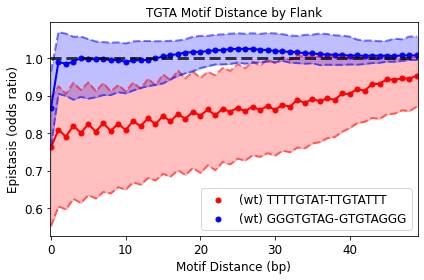

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


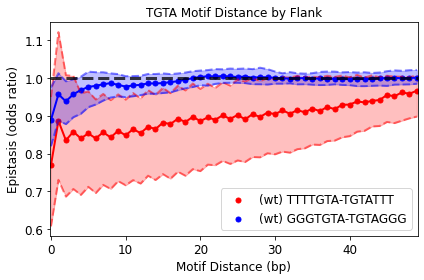

In [45]:
#Dual TGTA motif analysis: WT compositions and synthetic compositions

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_NUDT21_dual_TGTA'

load_from_cache = True
cache_name = 'apa_perturb_covar_dual_tgta_insertion_3_epi_scores'

hypo_names = [
    "TGTA Motif Distance by Flank",
    "TGTA Motif Distance by Flank",
    "TGTA Motif Distance by Flank",
    "TGTA Motif Distance by Flank",
]

sim_indexes = [
    [0, 1],
    [2, 3],
    [4, 5],
    [6, 7],
]

sim_color_maps = [
    ['red', 'blue'],
    ['red', 'blue'],
    ['red', 'blue'],
    ['red', 'blue'],
]

x_ranges = [
    [0, 50],
    [0, 50],
    [0, 50],
    [0, 50],
]

plot_areas = [
    True,
    True,
    True,
    True,
]

fig_names = [
    fig_name + "_wt_TGTA_TGTA_flank_TTT_GGG",
    fig_name + "_wt_TGTA_TGTA_flank_TT_GG",
    fig_name + "_wt_TGTA_TGTA_flank_T_G",
    fig_name + "_wt_TGTA_TGTA_flank",
]

_run_insertional_motif_simulation(sim_seqs, sim_motifs, sim_pos_funcs, sim_names, cell_type_1_ix=0, cell_type_2_ix=6, score_ix=2, load_from_cache=load_from_cache, cache_name=cache_name, hypo_names=hypo_names, sim_indexes=sim_indexes, sim_color_maps=sim_color_maps, x_ranges=x_ranges, plot_areas=plot_areas, fig_names=fig_names, save_figs=save_figs)


In [46]:
#Find sequences without wildtype TGTA motifs (gradient of flank composition)

n_wt = 64

df['n_tgta'] = df['seq'].str.slice(0, 70).str.count("TGTA")
df['cano_cse'] = df['seq'].str.slice(70, 76).str.contains("AATAAA|ATTAAA|AGTAAA|TATAAA|GATAAA|CATAAA")
df['use_cse'] = df['seq'].str.slice(0, 70).str.contains("AATAAA|ATTAAA")

df['A'] = df['seq'].str.slice(0, 70).str.count("A") / 70.
df['C'] = df['seq'].str.slice(0, 70).str.count("C") / 70.
df['G'] = df['seq'].str.slice(0, 70).str.count("G") / 70.
df['T'] = df['seq'].str.slice(0, 70).str.count("T") / 70.

wt_index = np.nonzero((((df['n_tgta'] == 0) & (df['cano_cse'] == 1)) & (df['use_cse'] == 0)).values)[0][:n_wt]

seqs_wt = df.iloc[wt_index]['seq'].values.tolist()

print("len(seqs_wt) = " + str(len(seqs_wt)))

sim_seqs = [
    seqs_wt,
    seqs_wt,
    seqs_wt,
    seqs_wt,
    seqs_wt,
    seqs_wt,
    seqs_wt,
]

sim_motifs = [
    ["TTTTGTATTT", "TTTTGTATTT"],
    ["GGTTGTATTG", "GGTTGTATTG"],
    ["GGTTGTATGG", "GGTTGTATGG"],
    ["GCGTGTACGG", "GCGTGTACGG"],
    ["GCGTGTAGCG", "GCGTGTAGCG"],
    ["GCGTGTAGGG", "GCGTGTAGGG"],
    ["GGGTGTAGGG", "GGGTGTAGGG"],
]

sim_names = [
    "(wt) TTTTGTATTT-TTTTGTATTT",
    "(wt) GGTTGTATTG-GGTTGTATTG",
    "(wt) GGTTGTATGG-GGTTGTATGG",
    "(wt) GCGTGTACGG-GCGTGTACGG",
    "(wt) GCGTGTAGCG-GCGTGTAGCG",
    "(wt) GCGTGTAGGG-GCGTGTAGGG",
    "(wt) GGGTGTAGGG-GGGTGTAGGG",
]


len(seqs_wt) = 64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


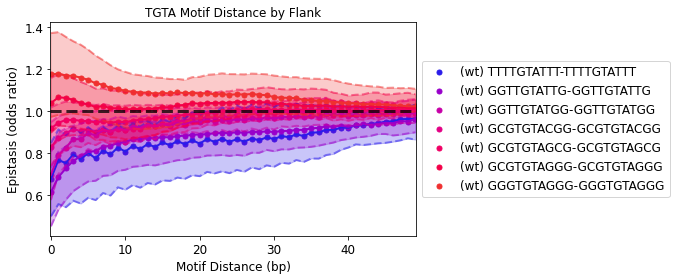

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


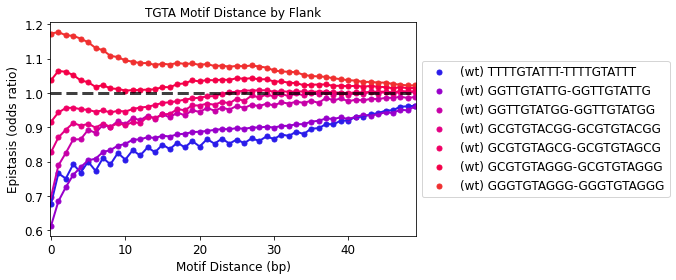

In [49]:
#Dual TGTA motif analysis: WT compositions and synthetic compositions

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_NUDT21_dual_TGTA'

load_from_cache = True
cache_name = 'apa_perturb_covar_dual_tgta_insertion_4_epi_scores'

hypo_names = [
    "TGTA Motif Distance by Flank",
    "TGTA Motif Distance by Flank",
]

sim_indexes = [
    [0, 1, 2, 3, 4, 5, 6],
    [0, 1, 2, 3, 4, 5, 6],
]

sim_color_maps = [
    ['#2a1cea', '#9800cb', '#c700a8', '#e30085', '#f10065', '#f40048', '#f03030'],
    ['#2a1cea', '#9800cb', '#c700a8', '#e30085', '#f10065', '#f40048', '#f03030'],
]

x_ranges = [
    [0, 50],
    [0, 50],
]

plot_areas = [
    True,
    False,
]

fig_names = [
    fig_name + "_wt_TGTA_TGTA_flank_gradient",
    fig_name + "_wt_TGTA_TGTA_flank_gradient_no_area",
]

_run_insertional_motif_simulation(sim_seqs, sim_motifs, sim_pos_funcs, sim_names, cell_type_1_ix=0, cell_type_2_ix=6, score_ix=2, load_from_cache=load_from_cache, cache_name=cache_name, hypo_names=hypo_names, sim_indexes=sim_indexes, sim_color_maps=sim_color_maps, x_ranges=x_ranges, plot_areas=plot_areas, fig_names=fig_names, plot_label_outside=True, save_figs=save_figs)


Processing features for PAS 0...
Processing features for PAS 1...
Processing features for PAS 2...
Processing features for PAS 3...
Processing features for PAS 4...
Processing features for PAS 5...
Processing features for PAS 6...
Processing features for PAS 7...
Processing features for PAS 8...
Processing features for PAS 9...
Done.
x_feat.shape = (5267, 10, 2)

y_lor_kept.shape = (4474,)
x_feat_train.shape = (3974, 4)
x_feat_test.shape = (500, 4)
y_lor_train.shape = (3974,)
y_lor_test.shape = (500,)

[4312.  888.]
[3009.  674.]
Bootstrap = 0
Bootstrap = 500
(train) r = 0.263
 (test) r = 0.18
   (cv) r = 0.223


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


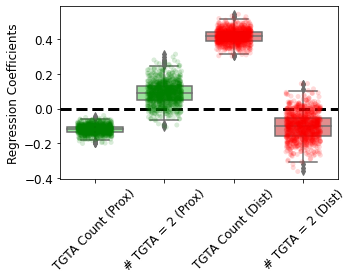

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


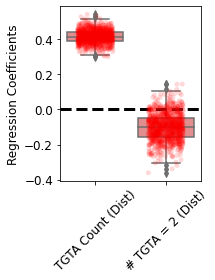

In [27]:
#Linear Model: Dual TGTA interaction

#Make polynomial regression features for data (TGTA)

#Re-load dataframe
df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

motifs = [
    'TGTAA|TGTAT|TTGTA',
]

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_NUDT21_dual_TGTA'

cell_type_1_ix = 0
cell_type_2_ix = 6

nth_order = 2
up_len = 70

x_feats = []
x_feat_str = []
for k in range(m.shape[1]) :
    
    print("Processing features for PAS " + str(k) + "...")
    
    df.loc[df['pas_exists_' + str(k)] == 0, 'wide_seq_ext_' + str(k)] = 'X' * 205
    
    x_feats_k = []
    
    #Single motif counts
    for motif_ix, motif in enumerate(motifs) :
        
        df[motif + "_" + str(k)] = df['wide_seq_ext_' + str(k)].str.slice(175-up_len-len(motif)+1, 175+len(motif)-1).str.count(motif)#.apply(lambda x: x.count(motif))
        
        x_feats_k.append(df[motif + "_" + str(k)].values[:, None, None])
        
        if k == 0 :
            x_feat_str.append(motif)
    
    #Combinatorial model indicators
    for motif_ix, motif in enumerate(motifs) :
        for orde in range(2, nth_order+1) :
        
            df[motif + "_" + str(orde) + "_" + str(k)] = (df['wide_seq_ext_' + str(k)].str.slice(175-up_len-len(motif)+1, 175+len(motif)-1).str.count(motif) == orde).astype(int)#.apply(lambda x: 1 if x.count(motif) == orde else 0)

            x_feats_k.append(df[motif + "_" + str(orde) + "_" + str(k)].values[:, None, None])

            if k == 0 :
                x_feat_str.append(motif + "_" + str(orde))
    
    x_feats.append(np.concatenate(x_feats_k, axis=2))

x_feat = np.concatenate(x_feats, axis=1)

print("Done.")

print("x_feat.shape = " + str(x_feat.shape))
print("")

#Run regression and get coefficients
cell_type_1_ix_global = cell_type_dict[subset_cell_types[cell_type_1_ix]]
cell_type_2_ix_global = cell_type_dict[subset_cell_types[cell_type_2_ix]]

keep_index = np.nonzero((np.max(np.sum(x_feat[..., :len(motifs)], axis=-1), axis=-1) <= nth_order) & (((y_dist[:, cell_type_1_ix_global] > 0.) & (y_dist[:, cell_type_1_ix_global] < 1.)) & ((y_dist[:, cell_type_2_ix_global] > 0.) & (y_dist[:, cell_type_2_ix_global] < 1.))))[0]

coefs = _perform_regression(x_feat, motifs, nth_order, keep_index, cell_type_1_ix=cell_type_1_ix, cell_type_2_ix=cell_type_2_ix, n_test=500)

#Analyze regression coeffients (Proximal and Distal)

import seaborn as sns
from scipy.stats import ranksums

n_f = x_feat.shape[-1]

w_prox = coefs[:, 0*n_f:1*n_f]
w_dist = coefs[:, 1*n_f:2*n_f]

w_prox_d = w_prox[:, :len(motifs)]
w_prox_dd = w_prox[:, len(motifs):]

w_dist_d = w_dist[:, :len(motifs)]
w_dist_dd = w_dist[:, len(motifs):]

f = plt.figure(figsize=(5, 4))

sns.stripplot(data=[
    w_prox_d[:, 0],
    w_prox_dd[:, 0],
    w_dist_d[:, 0],
    w_dist_dd[:, 0],
], alpha=0.15, jitter=0.25, palette=[
    'green',
    'green',
    'red',
    'red',
])
sns.boxplot(data=[
    w_prox_d[:, 0],
    w_prox_dd[:, 0],
    w_dist_d[:, 0],
    w_dist_dd[:, 0],
], palette=[
    'lightgreen',
    'lightgreen',
    'lightcoral',
    'lightcoral',
])

plt.axhline(y=0., color='black', linestyle='--', linewidth=3)

plt.xticks(np.arange(4).tolist(), [
    "TGTA Count (Prox)",
    "# TGTA = 2 (Prox)",
    "TGTA Count (Dist)",
    "# TGTA = 2 (Dist)",
], fontsize=12, rotation=45)

plt.yticks(fontsize=12)

plt.ylabel("Regression Coefficients", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_regression_coef.png", transparent=True, dpi=600)
    plt.savefig(fig_name + "_regression_coef.eps")

plt.show()

#Analyze regression coeffients (Distal only)

import seaborn as sns
from scipy.stats import ranksums

n_f = x_feat.shape[-1]

w_dist = coefs[:, 1*n_f:2*n_f]

w_dist_d = w_dist[:, :len(motifs)]
w_dist_dd = w_dist[:, len(motifs):]

f = plt.figure(figsize=(3, 4))

sns.stripplot(data=[
    w_dist_d[:, 0],
    w_dist_dd[:, 0],
], alpha=0.15, jitter=0.25, palette=['red', 'red'])

sns.boxplot(data=[
    w_dist_d[:, 0],
    w_dist_dd[:, 0],
], palette=['lightcoral', 'lightcoral'])

plt.axhline(y=0., color='black', linestyle='--', linewidth=3)

plt.xticks(np.arange(2).tolist(), [
    "TGTA Count (Dist)",
    "# TGTA = 2 (Dist)",
], fontsize=12, rotation=45)

plt.yticks(fontsize=12)

plt.ylabel("Regression Coefficients", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_regression_coef_dist_only.png", transparent=True, dpi=600)
    plt.savefig(fig_name + "_regression_coef_dist_only.eps")

plt.show()


Processing features for PAS 0...
Processing features for PAS 1...
Processing features for PAS 2...
Processing features for PAS 3...
Processing features for PAS 4...
Processing features for PAS 5...
Processing features for PAS 6...
Processing features for PAS 7...
Processing features for PAS 8...
Processing features for PAS 9...
Done.
x_feat.shape = (5267, 10, 4)

y_lor_kept.shape = (5017,)
x_feat_train.shape = (4817, 8)
x_feat_test.shape = (200, 8)
y_lor_train.shape = (4817,)
y_lor_test.shape = (200,)

[5941. 1003.  275.   61.]
[4009.  715.  200.   42.]
Bootstrap = 0
Bootstrap = 500
(train) r = 0.275
 (test) r = 0.205
   (cv) r = 0.248


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


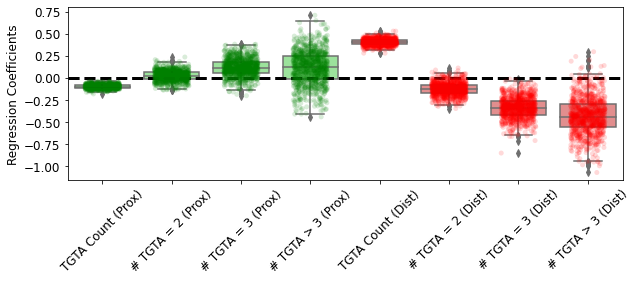

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


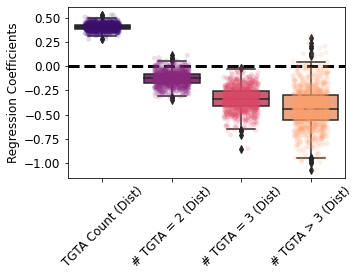

In [30]:
#Linear Model: Multi TGTA interaction

#Make polynomial regression features for data (TGTA)

#Re-load dataframe
df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

motifs = [
    'TGTAA|TGTAT|TTGTA',
]

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_NUDT21_multi_TGTA'

cell_type_1_ix = 0
cell_type_2_ix = 6

nth_order = 5
up_len = 70

x_feats = []
x_feat_str = []
for k in range(m.shape[1]) :
    
    print("Processing features for PAS " + str(k) + "...")
    
    df.loc[df['pas_exists_' + str(k)] == 0, 'wide_seq_ext_' + str(k)] = 'X' * 205
    
    x_feats_k = []
    
    #Single motif counts
    for motif_ix, motif in enumerate(motifs) :
        
        df[motif + "_" + str(k)] = df['wide_seq_ext_' + str(k)].str.slice(175-up_len-len(motif)+1, 175+len(motif)-1).str.count(motif)#.apply(lambda x: x.count(motif))
        
        x_feats_k.append(df[motif + "_" + str(k)].values[:, None, None])
        
        if k == 0 :
            x_feat_str.append(motif)
    
    #Combinatorial model indicators
    for motif_ix, motif in enumerate(motifs) :
        for orde in range(2, nth_order+1) :
        
            df[motif + "_" + str(orde) + "_" + str(k)] = (df['wide_seq_ext_' + str(k)].str.slice(175-up_len-len(motif)+1, 175+len(motif)-1).str.count(motif) == orde).astype(int)#.apply(lambda x: 1 if x.count(motif) == orde else 0)

            x_feats_k.append(df[motif + "_" + str(orde) + "_" + str(k)].values[:, None, None])

            if k == 0 :
                x_feat_str.append(motif + "_" + str(orde))
    
    x_feats.append(np.concatenate(x_feats_k, axis=2))

x_feat = np.concatenate(x_feats, axis=1)

print("Done.")

#Due to small sample sizes, group TGTA count = 4 and 5 together

x_feat[:, :, 3] += x_feat[:, :, 4]
x_feat = x_feat[..., :4]

print("x_feat.shape = " + str(x_feat.shape))
print("")

#Run regression and get coefficients
cell_type_1_ix_global = cell_type_dict[subset_cell_types[cell_type_1_ix]]
cell_type_2_ix_global = cell_type_dict[subset_cell_types[cell_type_2_ix]]

keep_index = np.nonzero((np.max(np.sum(x_feat[..., :len(motifs)], axis=-1), axis=-1) <= nth_order) & (((y_dist[:, cell_type_1_ix_global] > 0.) & (y_dist[:, cell_type_1_ix_global] < 1.)) & ((y_dist[:, cell_type_2_ix_global] > 0.) & (y_dist[:, cell_type_2_ix_global] < 1.))))[0]

coefs = _perform_regression(x_feat, motifs, nth_order, keep_index, cell_type_1_ix=cell_type_1_ix, cell_type_2_ix=cell_type_2_ix, n_test=200)

#Analyze regression coeffients (Proximal and Distal)

import seaborn as sns
from scipy.stats import ranksums

n_f = x_feat.shape[-1]

w_prox = coefs[:, 0*n_f:1*n_f]
w_dist = coefs[:, 1*n_f:2*n_f]

w_prox_d = w_prox[:, :len(motifs)]
w_prox_dd = w_prox[:, len(motifs):]

w_dist_d = w_dist[:, :len(motifs)]
w_dist_dd = w_dist[:, len(motifs):]

f = plt.figure(figsize=(9, 4))

sns.stripplot(data=[
    w_prox_d[:, 0],
    w_prox_dd[:, 0],
    w_prox_dd[:, 1],
    w_prox_dd[:, 2],
    w_dist_d[:, 0],
    w_dist_dd[:, 0],
    w_dist_dd[:, 1],
    w_dist_dd[:, 2],
], alpha=0.15, jitter=0.25, palette=[
    'green',
    'green',
    'green',
    'green',
    'red',
    'red',
    'red',
    'red',
])
sns.boxplot(data=[
    w_prox_d[:, 0],
    w_prox_dd[:, 0],
    w_prox_dd[:, 1],
    w_prox_dd[:, 2],
    w_dist_d[:, 0],
    w_dist_dd[:, 0],
    w_dist_dd[:, 1],
    w_dist_dd[:, 2],
], palette=[
    'lightgreen',
    'lightgreen',
    'lightgreen',
    'lightgreen',
    'lightcoral',
    'lightcoral',
    'lightcoral',
    'lightcoral',
])

plt.axhline(y=0., color='black', linestyle='--', linewidth=3)

plt.xticks(np.arange(8).tolist(), [
    "TGTA Count (Prox)",
    "# TGTA = 2 (Prox)",
    "# TGTA = 3 (Prox)",
    "# TGTA > 3 (Prox)",
    "TGTA Count (Dist)",
    "# TGTA = 2 (Dist)",
    "# TGTA = 3 (Dist)",
    "# TGTA > 3 (Dist)",
], fontsize=12, rotation=45)

plt.yticks(fontsize=12)

plt.ylabel("Regression Coefficients", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_regression_coef.png", transparent=True, dpi=600)
    plt.savefig(fig_name + "_regression_coef.eps")

plt.show()

#Analyze regression coeffients (Distal only)

import seaborn as sns
from scipy.stats import ranksums

n_f = x_feat.shape[-1]

w_dist = coefs[:, 1*n_f:2*n_f]

w_dist_d = w_dist[:, :len(motifs)]
w_dist_dd = w_dist[:, len(motifs):]

f = plt.figure(figsize=(5, 4))

sns.stripplot(data=[
    w_dist_d[:, 0],
    w_dist_dd[:, 0],
    w_dist_dd[:, 1],
    w_dist_dd[:, 2],
], alpha=0.15, jitter=0.25, palette='magma')

sns.boxplot(data=[
    w_dist_d[:, 0],
    w_dist_dd[:, 0],
    w_dist_dd[:, 1],
    w_dist_dd[:, 2],
], palette='magma')

plt.axhline(y=0., color='black', linestyle='--', linewidth=3)

plt.xticks(np.arange(4).tolist(), [
    "TGTA Count (Dist)",
    "# TGTA = 2 (Dist)",
    "# TGTA = 3 (Dist)",
    "# TGTA > 3 (Dist)",
], fontsize=12, rotation=45)

plt.yticks(fontsize=12)

plt.ylabel("Regression Coefficients", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_regression_coef_dist_only.png", transparent=True, dpi=600)
    plt.savefig(fig_name + "_regression_coef_dist_only.eps")

plt.show()


Processing features for PAS 0...
Processing features for PAS 1...
Processing features for PAS 2...
Processing features for PAS 3...
Processing features for PAS 4...
Processing features for PAS 5...
Processing features for PAS 6...
Processing features for PAS 7...
Processing features for PAS 8...
Processing features for PAS 9...
Done.
x_feat.shape = (5267, 10, 5)

y_lor_kept.shape = (4076,)
x_feat_train.shape = (3576, 10)
x_feat_test.shape = (500, 10)
y_lor_train.shape = (3576,)
y_lor_test.shape = (500,)

[4649.   58.  328.  407.  216.]
[3276.   49.  278.  323.  160.]
Bootstrap = 0
Bootstrap = 500
(train) r = 0.274
 (test) r = 0.214
   (cv) r = 0.242


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


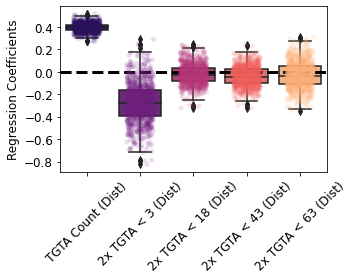

In [31]:
#Linear Model: Dual TGTA interaction (by distance)

#Make positional polynomial regression features for data (TGTA)

import regex as re

#Re-load dataframe
df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

motifs = [
    re.compile(r'TGTA'),
]

motif_names = [
    'TGTA',
]

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_NUDT21_dual_positional_TGTA'

cell_type_1_ix = 0
cell_type_2_ix = 6

nth_order = 2
up_len = 100

dists = [10, 25, 50, 75]

x_feats = []
x_feat_str = []
for k in range(m.shape[1]) :
    
    print("Processing features for PAS " + str(k) + "...")
    
    df.loc[df['pas_exists_' + str(k)] == 0, 'wide_seq_ext_' + str(k)] = 'X' * 205
    
    x_feats_k = []
    
    #Single motif counts
    for motif_ix, [motif, motif_name] in enumerate(zip(motifs, motif_names)) :
        
        df[motif_name + "_" + str(k)] = df['wide_seq_ext_' + str(k)].str.slice(175-up_len, 175).apply(lambda x: len(re.findall(motif, x)))
        
        x_feats_k.append(df[motif_name + "_" + str(k)].values[:, None, None])
        
        if k == 0 :
            x_feat_str.append(motif_name)
    
    #Combinatorial model indicators
    for motif_ix, [motif, motif_name] in enumerate(zip(motifs, motif_names)) :
        
        for dist_ix, dist in enumerate(dists) :
            
            for orde in range(2, nth_order+1) :
            
                df[motif_name + "_" + str(orde) + "_" + str(dist) + "_" + str(k)] = 0.

                for start_pos in range(0, up_len - dist + 1) :
                    
                    if dist_ix == 0 :
                        df[motif_name + "_" + str(orde) + "_" + str(dist) + "_" + str(k)] = np.maximum(df[motif_name + "_" + str(orde) + "_" + str(dist) + "_" + str(k)].values, df['wide_seq_ext_' + str(k)].str.slice(175-up_len+start_pos, 175-up_len+start_pos+dist).apply(lambda x: 1 if len(re.findall(motif, x)) == orde else 0).values)
                    else :
                         df[motif_name + "_" + str(orde) + "_" + str(dist) + "_" + str(k)] = np.maximum(np.maximum(df[motif_name + "_" + str(orde) + "_" + str(dist) + "_" + str(k)].values, df['wide_seq_ext_' + str(k)].str.slice(175-up_len+start_pos, 175-up_len+start_pos+dist).apply(lambda x: 1 if len(re.findall(motif, x)) == orde else 0).values) - np.sum(np.concatenate([df[motif_name + "_" + str(orde) + "_" + str(dists[prev_dist_ix]) + "_" + str(k)].values[:, None] for prev_dist_ix in range(0, dist_ix)], axis=-1), axis=-1), 0.)
                    
                x_feats_k.append(df[motif_name + "_" + str(orde) + "_" + str(dist)  + "_" + str(k)].values[:, None, None])

                if k == 0 :
                    x_feat_str.append(motif_name + "_" + str(orde) + "_" + str(dist) )
    
    x_feats.append(np.concatenate(x_feats_k, axis=2))

x_feat = np.concatenate(x_feats, axis=1)

print("Done.")

print("x_feat.shape = " + str(x_feat.shape))
print("")

#Run regression and get coefficients
cell_type_1_ix_global = cell_type_dict[subset_cell_types[cell_type_1_ix]]
cell_type_2_ix_global = cell_type_dict[subset_cell_types[cell_type_2_ix]]

keep_index = np.nonzero((np.max(np.sum(x_feat[..., :len(motifs)], axis=-1), axis=-1) <= nth_order) & (((y_dist[:, cell_type_1_ix_global] > 0.) & (y_dist[:, cell_type_1_ix_global] < 1.)) & ((y_dist[:, cell_type_2_ix_global] > 0.) & (y_dist[:, cell_type_2_ix_global] < 1.))))[0]

coefs = _perform_regression(x_feat, motifs, nth_order, keep_index, cell_type_1_ix=cell_type_1_ix, cell_type_2_ix=cell_type_2_ix, n_test=500)

#Analyze regression coeffients (Proximal and Distal)

import seaborn as sns
from scipy.stats import ranksums

n_f = x_feat.shape[-1]

w_prox = coefs[:, 0*n_f:1*n_f]
w_dist = coefs[:, 1*n_f:2*n_f]

w_prox_d = w_prox[:, :len(motifs)]
w_prox_dd = w_prox[:, len(motifs):]

w_dist_d = w_dist[:, :len(motifs)]
w_dist_dd = w_dist[:, len(motifs):]

f = plt.figure(figsize=(5, 4))

sns.stripplot(data=[
    w_dist_d[:, 0],
    w_dist_dd[:, 0],
    w_dist_dd[:, 1],
    w_dist_dd[:, 2],
    w_dist_dd[:, 3],
], alpha=0.15, jitter=0.25, palette='magma')

sns.boxplot(data=[
    w_dist_d[:, 0],
    w_dist_dd[:, 0],
    w_dist_dd[:, 1],
    w_dist_dd[:, 2],
    w_dist_dd[:, 3],
], palette='magma')

plt.axhline(y=0., color='black', linestyle='--', linewidth=3)

plt.xticks(np.arange(5).tolist(), [
    "TGTA Count (Dist)",
    "2x TGTA < 3 (Dist)",
    "2x TGTA < 18 (Dist)",
    "2x TGTA < 43 (Dist)",
    "2x TGTA < 63 (Dist)",
], fontsize=12, rotation=45)

plt.yticks(fontsize=12)

plt.ylabel("Regression Coefficients", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_regression_coef_dist_only.png", transparent=True, dpi=600)
    plt.savefig(fig_name + "_regression_coef_dist_only.eps")

plt.show()


Processing features for PAS 0...
Processing features for PAS 1...
Processing features for PAS 2...
Processing features for PAS 3...
Processing features for PAS 4...
Processing features for PAS 5...
Processing features for PAS 6...
Processing features for PAS 7...
Processing features for PAS 8...
Processing features for PAS 9...
Done.
x_feat.shape = (5267, 10, 4)

y_lor_kept.shape = (1363,)
x_feat_train.shape = (1163, 8)
x_feat_test.shape = (200, 8)
y_lor_train.shape = (1163,)
y_lor_test.shape = (200,)

[1016.   51.   23.   22.]
[673.  28.  21.  11.]
Bootstrap = 0
Bootstrap = 500
(train) r = 0.178
 (test) r = 0.029
   (cv) r = 0.03


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


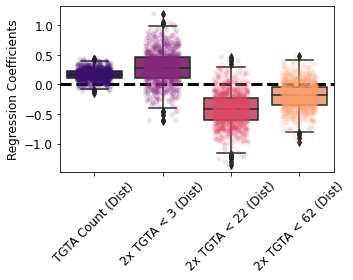

In [32]:
#Linear Model: Dual TGTA interaction (by distance; GC-rich flank composition)

#Make positional polynomial regression features for data (TGTA; GC-rich composition)

import regex as re

#Re-load dataframe
df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

motifs = [
    re.compile(r'([CAG][CAG][CAG].?TGTA.?[CAG][CAG][CAG])|([CAG][CAG].?TGTA(?=[CAG]*TGTA.?[CAG][CAG]))|((?<=[CAG][CAG].?TGTA[CAG]*)TGTA.?[CAG][CAG])'),
]

motif_names = [
    'TGTA[C/G]',
]

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_NUDT21_dual_positional_TGTA_GC'

cell_type_1_ix = 0
cell_type_2_ix = 6

nth_order = 2
up_len = 100

dists = [16, 35, 75]

x_feats = []
x_feat_str = []
for k in range(m.shape[1]) :
    
    print("Processing features for PAS " + str(k) + "...")
    
    df.loc[df['pas_exists_' + str(k)] == 0, 'wide_seq_ext_' + str(k)] = 'X' * 205
    
    x_feats_k = []
    
    #Single motif counts
    for motif_ix, [motif, motif_name] in enumerate(zip(motifs, motif_names)) :
        
        df[motif_name + "_" + str(k)] = df['wide_seq_ext_' + str(k)].str.slice(175-up_len, 175).apply(lambda x: len(re.findall(motif, x)))
        
        x_feats_k.append(df[motif_name + "_" + str(k)].values[:, None, None])
        
        if k == 0 :
            x_feat_str.append(motif_name)
    
    #Combinatorial model indicators
    for motif_ix, [motif, motif_name] in enumerate(zip(motifs, motif_names)) :
        
        for dist_ix, dist in enumerate(dists) :
            
            for orde in range(2, nth_order+1) :
            
                df[motif_name + "_" + str(orde) + "_" + str(dist) + "_" + str(k)] = 0.

                for start_pos in range(0, up_len - dist + 1) :
                    
                    if dist_ix == 0 :
                        df[motif_name + "_" + str(orde) + "_" + str(dist) + "_" + str(k)] = np.maximum(df[motif_name + "_" + str(orde) + "_" + str(dist) + "_" + str(k)].values, df['wide_seq_ext_' + str(k)].str.slice(175-up_len+start_pos, 175-up_len+start_pos+dist).apply(lambda x: 1 if len(re.findall(motif, x)) == orde else 0).values)
                    else :
                         df[motif_name + "_" + str(orde) + "_" + str(dist) + "_" + str(k)] = np.maximum(np.maximum(df[motif_name + "_" + str(orde) + "_" + str(dist) + "_" + str(k)].values, df['wide_seq_ext_' + str(k)].str.slice(175-up_len+start_pos, 175-up_len+start_pos+dist).apply(lambda x: 1 if len(re.findall(motif, x)) == orde else 0).values) - np.sum(np.concatenate([df[motif_name + "_" + str(orde) + "_" + str(dists[prev_dist_ix]) + "_" + str(k)].values[:, None] for prev_dist_ix in range(0, dist_ix)], axis=-1), axis=-1), 0.)
                    
                x_feats_k.append(df[motif_name + "_" + str(orde) + "_" + str(dist)  + "_" + str(k)].values[:, None, None])

                if k == 0 :
                    x_feat_str.append(motif_name + "_" + str(orde) + "_" + str(dist) )
    
    x_feats.append(np.concatenate(x_feats_k, axis=2))

x_feat = np.concatenate(x_feats, axis=1)

print("Done.")

print("x_feat.shape = " + str(x_feat.shape))
print("")

#Run regression and get coefficients
cell_type_1_ix_global = cell_type_dict[subset_cell_types[cell_type_1_ix]]
cell_type_2_ix_global = cell_type_dict[subset_cell_types[cell_type_2_ix]]

keep_index = np.nonzero(((np.max(np.sum(x_feat[..., :len(motifs)], axis=-1), axis=-1) <= nth_order) & (np.max(np.sum(x_feat[..., :len(motifs)], axis=-1), axis=-1) >= 1)) & (((y_dist[:, cell_type_1_ix_global] > 0.) & (y_dist[:, cell_type_1_ix_global] < 1.)) & ((y_dist[:, cell_type_2_ix_global] > 0.) & (y_dist[:, cell_type_2_ix_global] < 1.))))[0]

coefs = _perform_regression(x_feat, motifs, nth_order, keep_index, cell_type_1_ix=cell_type_1_ix, cell_type_2_ix=cell_type_2_ix, n_test=200)

#Analyze regression coeffients (Proximal and Distal)

import seaborn as sns
from scipy.stats import ranksums

n_f = x_feat.shape[-1]

w_prox = coefs[:, 0*n_f:1*n_f]
w_dist = coefs[:, 1*n_f:2*n_f]

w_prox_d = w_prox[:, :len(motifs)]
w_prox_dd = w_prox[:, len(motifs):]

w_dist_d = w_dist[:, :len(motifs)]
w_dist_dd = w_dist[:, len(motifs):]

f = plt.figure(figsize=(5, 4))

sns.stripplot(data=[
    w_dist_d[:, 0],
    w_dist_dd[:, 0],
    w_dist_dd[:, 1],
    w_dist_dd[:, 2],
], alpha=0.15, jitter=0.25, palette='magma')

sns.boxplot(data=[
    w_dist_d[:, 0],
    w_dist_dd[:, 0],
    w_dist_dd[:, 1],
    w_dist_dd[:, 2],
], palette='magma')

plt.axhline(y=0., color='black', linestyle='--', linewidth=3)

plt.xticks(np.arange(4).tolist(), [
    "TGTA Count (Dist)",
    "2x TGTA < 3 (Dist)",
    "2x TGTA < 22 (Dist)",
    "2x TGTA < 62 (Dist)",
], fontsize=12, rotation=45)

plt.yticks(fontsize=12)

plt.ylabel("Regression Coefficients", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_regression_coef_dist_only.png", transparent=True, dpi=600)
    plt.savefig(fig_name + "_regression_coef_dist_only.eps")

plt.show()


In [33]:
#Analysis 2: Epistatic interaction (TGTA + GT-rich) in NUDT21

pattern_index = [1, 2, 3, 5, 10, 14, 15, 16, 17, 20, 22, 23, 27, 30, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 49]
pattern_index_other = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37]

#Find matches for UGUA motifs in NUDT21
all_pwm_matches = []
all_pwm_match_poses = []

modisco_f = modisco_fs[0]

for pattern_ix in pattern_index :

    pwm_match_l = modisco_f['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']["pattern_" + str(pattern_ix)]["seqlets_and_alnmts"]["seqlets"][()]#.keys()

    pwm_matches_t = [int(str(s).split("example:")[1].split(",")[0]) for s in pwm_match_l.tolist() if "rc:" in str(s)]
    pwm_match_poses_t = [int(str(s).split("start:")[1].split(",")[0]) for s in pwm_match_l.tolist() if "rc:" in str(s)]
    
    #print(len(pwm_matches))
    
    all_pwm_matches.extend(pwm_matches_t)
    all_pwm_match_poses.extend(pwm_match_poses_t)

pwm_matches = np.unique(all_pwm_matches).tolist()
not_pwm_matches = [i for i in np.arange(flat_ts.shape[0]).tolist() if i not in set(pwm_matches)]

pwm_match_index = all_pwm_matches
pwm_match_poses = all_pwm_match_poses

print(len(pwm_matches))
print(len(not_pwm_matches))

#Find matches for GT/CT/T-rich motifs in CSTF3
all_pwm_matches_other = []
all_pwm_match_poses_other = []

modisco_f = modisco_fs[1]

for pattern_ix in pattern_index_other :

    pwm_match_l = modisco_f['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']["pattern_" + str(pattern_ix)]["seqlets_and_alnmts"]["seqlets"][()]#.keys()

    pwm_matches_t = [int(str(s).split("example:")[1].split(",")[0]) for s in pwm_match_l.tolist() if "rc:" in str(s)]
    pwm_match_poses_t = [int(str(s).split("start:")[1].split(",")[0]) for s in pwm_match_l.tolist() if "rc:" in str(s)]
    
    #print(len(pwm_matches))
    
    all_pwm_matches_other.extend(pwm_matches_t)
    all_pwm_match_poses_other.extend(pwm_match_poses_t)

pwm_matches_other = np.unique(all_pwm_matches_other).tolist()
not_pwm_matches_other = [i for i in np.arange(flat_ts.shape[0]).tolist() if i not in set(pwm_matches_other)]

pwm_match_index_other = all_pwm_matches_other
pwm_match_poses_other = all_pwm_match_poses_other

print(len(pwm_matches_other))
print(len(not_pwm_matches_other))

#Construct mask to extract select motif hits from importance scores
pwm_match_mask = np.zeros((flat_scores.shape[2], flat_scores.shape[4], flat_scores.shape[5]))
pwm_match_mask_other = np.zeros((flat_scores.shape[2], flat_scores.shape[4], flat_scores.shape[5]))

for pwm_match_ix, pwm_match_pos in zip(pwm_match_index, pwm_match_poses) :
    
    pwm_match_mask[pwm_match_ix, pwm_match_pos:pwm_match_pos+pattern_width, :] = 1.

for pwm_match_ix, pwm_match_pos in zip(pwm_match_index_other, pwm_match_poses_other) :
    
    pwm_match_mask_other[pwm_match_ix, pwm_match_pos:pwm_match_pos+pattern_width, :] = 1.


4583
10181
6585
8179


s_abl_both - s_ref (median) = 2.1352
s_abl_1 - s_ref (median) = 1.5244
s_abl_2 - s_ref (median) = 0.6181


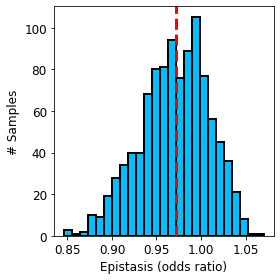

Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
epi_scores.shape = (1788,)
epi_scores_null.shape = (1788,)
wilcoxon p = 2.0314128066930712e-29


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


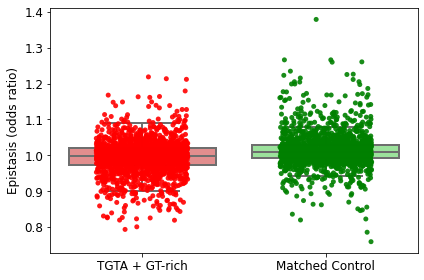

In [65]:
#Analyze epistatic interaction (TGTA + GT-rich)

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_NUDT21_TGTA_GT_rich'

#Single example
_analyze_epistatics(i=189, n_samples=1024, cell_type_1_ix=0, cell_type_2_ix=6, score_ix=2, region_1=[[2, 2+5], [20, 20+5], [48, 48+5]], region_2=[[101, 110]], save_figs=save_figs, fig_name=fig_name)

#All motif hits
subset_index = np.nonzero((np.sum(pwm_match_mask[:, 70:76, 0], axis=-1) == 0.) & ((np.sum(pwm_match_mask[:, :70, 0], axis=-1) >= 10. - 1.) & (np.sum(pwm_match_mask_other[:, 76:, 0], axis=-1) >= 10. - 1.)))[0].tolist()
_valid_null_pos_func = lambda i, start_1, start_2, pattern_width, pwm_match_mask, pwm_match_mask_other: [j for j in range(70, 146 - pattern_width) if np.sum(pwm_match_mask_other[i, j:j+pattern_width, 0]) <= 0.]

_analyze_epistatics_many_heterotypic(subset_index, pwm_match_mask, pwm_match_mask_other, pwm_match_index, pwm_match_index_other, pwm_match_poses, pwm_match_poses_other, cell_type_1_ix=0, cell_type_2_ix=6, score_ix=2, n_samples=32, _valid_null_pos_func=_valid_null_pos_func, hypo_str="TGTA + GT-rich", save_figs=save_figs, fig_name=fig_name)


Processing features for PAS 0...
Processing features for PAS 1...
Processing features for PAS 2...
Processing features for PAS 3...
Processing features for PAS 4...
Processing features for PAS 5...
Processing features for PAS 6...
Processing features for PAS 7...
Processing features for PAS 8...
Processing features for PAS 9...
Done.
x_feat.shape = (5267, 10, 3)

y_lor_kept.shape = (4591,)
x_feat_train.shape = (4091, 6)
x_feat_test.shape = (500, 6)
y_lor_train.shape = (4091,)
y_lor_test.shape = (500,)

[3089. 1934.  705.]
[2173. 1352.  635.]
Bootstrap = 0
Bootstrap = 500
(train) r = 0.265
 (test) r = 0.168
   (cv) r = 0.235


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


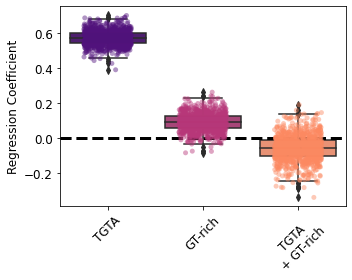

In [34]:
#Linear Model: TGTA + GT-rich interaction

#Make polynomial regression features for data (TGTA + GT-rich)

import regex as re

#Re-load dataframe
df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

motifs_1 = [
    re.compile(r'(TGTAT)|(TGTAA)|(TTGTA)'),
]
motif_names_1 = [
    'TGTA'
]

motifs_2 = [
    re.compile(r'(TGT[GCT]T)'),
    #re.compile(r'(T[GC]T[GC]T)|([GC]TTT[GC]T)|(T[GC]TTT[GC])|(T[G]TT[GC]T)'),
]
motif_names_2 = [
    'GTGT',
]

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_NUDT21_TGTA_and_GT_rich'

cell_type_1_ix = 0
cell_type_2_ix = 6

nth_order = 1

motif_1_region = [0, 70]
motif_2_region = [81, 111]

x_feats = []
x_feat_str = []
for k in range(m.shape[1]) :
    
    print("Processing features for PAS " + str(k) + "...")
    
    df.loc[df['pas_exists_' + str(k)] == 0, 'wide_seq_ext_' + str(k)] = 'X' * 356
    
    x_feats_k = []
    
    #Single motif 1 counts
    for motif_ix, motif in enumerate(motifs_1) :
        
        df[motif_names_1[motif_ix] + "_" + str(k)] = df['wide_seq_ext_' + str(k)].str.slice(105+motif_1_region[0], 105+motif_1_region[1]).apply(lambda x: 1 if re.search(motif, x) else 0)
        
        x_feats_k.append(df[motif_names_1[motif_ix] + "_" + str(k)].values[:, None, None])
        
        if k == 0 :
            x_feat_str.append(motif_names_1[motif_ix])
    
    #Single motif 2 counts
    for motif_ix, motif in enumerate(motifs_2) :
        
        df[motif_names_2[motif_ix] + "_" + str(k)] = df['wide_seq_ext_' + str(k)].str.slice(105+motif_2_region[0], 105+motif_2_region[1]).apply(lambda x: len(re.findall(motif, x)))
        
        x_feats_k.append(df[motif_names_2[motif_ix] + "_" + str(k)].values[:, None, None])
        
        if k == 0 :
            x_feat_str.append(motif_names_2[motif_ix])
    
    #Combinatorial model indicators
    for motif_1_ix, motif_1 in enumerate(motifs_1) :
        for motif_2_ix, motif_2 in enumerate(motifs_2) :
            for orde in range(1, nth_order+1) :
        
                df[motif_names_1[motif_1_ix] + "_" + motif_names_2[motif_2_ix] + "_" + str(orde) + "_" + str(k)] = df.apply(lambda row: 1 if row[motif_names_1[motif_1_ix] + "_" + str(k)] == 1 and row[motif_names_2[motif_2_ix] + "_" + str(k)] == orde else 0, axis=1)

                x_feats_k.append(df[motif_names_1[motif_1_ix] + "_" + motif_names_2[motif_2_ix] + "_" + str(orde) + "_" + str(k)].values[:, None, None])

                if k == 0 :
                    x_feat_str.append(motif_names_1[motif_1_ix] + "_" + motif_names_2[motif_2_ix] + "_" + str(orde))

    x_feats.append(np.concatenate(x_feats_k, axis=2))

x_feat = np.concatenate(x_feats, axis=1)

print("Done.")

print("x_feat.shape = " + str(x_feat.shape))
print("")

#Run regression and get coefficients
cell_type_1_ix_global = cell_type_dict[subset_cell_types[cell_type_1_ix]]
cell_type_2_ix_global = cell_type_dict[subset_cell_types[cell_type_2_ix]]

keep_index = np.nonzero((np.max(np.sum(x_feat[..., len(motifs_1):len(motifs_1)+len(motifs_2)], axis=-1), axis=-1) <= nth_order) & (((y_dist[:, cell_type_1_ix_global] > 0.) & (y_dist[:, cell_type_1_ix_global] < 1.)) & ((y_dist[:, cell_type_2_ix_global] > 0.) & (y_dist[:, cell_type_2_ix_global] < 1.))))[0]

coefs = _perform_regression(x_feat, motifs, nth_order, keep_index, cell_type_1_ix=cell_type_1_ix, cell_type_2_ix=cell_type_2_ix, n_test=500)

#Analyze regression coefficients (Distal only)

import seaborn as sns
from scipy.stats import ranksums

n_f = x_feat.shape[-1]

w_dist = coefs[:, 1*n_f:2*n_f]

w_dist_d1 = w_dist[:, :len(motifs_1)]
w_dist_d2 = w_dist[:, len(motifs_1):len(motifs_1)+len(motifs_2)]
w_dist_dd = w_dist[:, len(motifs_1)+len(motifs_2):]

f = plt.figure(figsize=(5, 4))

sns.stripplot(data=[
    w_dist_d1[:, 0],
    w_dist_d2[:, 0],
    w_dist_dd[:, 0],
    #w_dist_dd[:, 1],
    #w_dist_dd[:, 2],
], alpha=0.45, jitter=0.25, palette='magma')

sns.boxplot(data=[
    w_dist_d1[:, 0],
    w_dist_d2[:, 0],
    w_dist_dd[:, 0],
    #w_dist_dd[:, 1],
    #w_dist_dd[:, 2],
], palette='magma')

plt.axhline(y=0., color='black', linestyle='--', linewidth=3)

plt.xticks(np.arange(3).tolist(), [
    "TGTA",
    "GT-rich",
    "TGTA\n+ GT-rich",
    #"TGTA\n+ 2x GT-rich",
    #"TGTA\n+ 3x GT-rich",
], fontsize=12, rotation=45)

plt.yticks(fontsize=12)

plt.ylabel("Regression Coefficient", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_regression_coef_dist_only.png", transparent=True, dpi=600)
    plt.savefig(fig_name + "_regression_coef_dist_only.eps")

plt.show()


In [35]:
#Analysis 3: Epistatic interaction (AWTAAA + GT-rich) in RBBP6

pattern_index = [0, 2, 3, 4, 7, 10, 14, 23, 31, 33, 35, 36, 37]
pattern_index_other = [1, 5, 6, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 34, 38]

#Find matches for AWTAAA motifs in RBBP6
all_pwm_matches = []
all_pwm_match_poses = []

modisco_f = modisco_fs[2]

for pattern_ix in pattern_index :

    pwm_match_l = modisco_f['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']["pattern_" + str(pattern_ix)]["seqlets_and_alnmts"]["seqlets"][()]#.keys()

    pwm_matches_t = [int(str(s).split("example:")[1].split(",")[0]) for s in pwm_match_l.tolist() if "rc:" in str(s)]
    pwm_match_poses_t = [int(str(s).split("start:")[1].split(",")[0]) for s in pwm_match_l.tolist() if "rc:" in str(s)]
    
    #print(len(pwm_matches))
    
    all_pwm_matches.extend(pwm_matches_t)
    all_pwm_match_poses.extend(pwm_match_poses_t)

pwm_matches = np.unique(all_pwm_matches).tolist()
not_pwm_matches = [i for i in np.arange(flat_ts.shape[0]).tolist() if i not in set(pwm_matches)]

pwm_match_index = all_pwm_matches
pwm_match_poses = all_pwm_match_poses

print(len(pwm_matches))
print(len(not_pwm_matches))

#Find matches for GT/CT/T-rich motifs in RBBP6
all_pwm_matches_other = []
all_pwm_match_poses_other = []

modisco_f = modisco_fs[2]

for pattern_ix in pattern_index_other :

    pwm_match_l = modisco_f['metacluster_idx_to_submetacluster_results']['metacluster_0']['seqlets_to_patterns_result']['patterns']["pattern_" + str(pattern_ix)]["seqlets_and_alnmts"]["seqlets"][()]#.keys()

    pwm_matches_t = [int(str(s).split("example:")[1].split(",")[0]) for s in pwm_match_l.tolist() if "rc:" in str(s)]
    pwm_match_poses_t = [int(str(s).split("start:")[1].split(",")[0]) for s in pwm_match_l.tolist() if "rc:" in str(s)]
    
    #print(len(pwm_matches))
    
    all_pwm_matches_other.extend(pwm_matches_t)
    all_pwm_match_poses_other.extend(pwm_match_poses_t)

pwm_matches_other = np.unique(all_pwm_matches_other).tolist()
not_pwm_matches_other = [i for i in np.arange(flat_ts.shape[0]).tolist() if i not in set(pwm_matches_other)]

pwm_match_index_other = all_pwm_matches_other
pwm_match_poses_other = all_pwm_match_poses_other

print(len(pwm_matches_other))
print(len(not_pwm_matches_other))

#Construct mask to extract select motif hits from importance scores
pwm_match_mask = np.zeros((flat_scores.shape[2], flat_scores.shape[4], flat_scores.shape[5]))
pwm_match_mask_other = np.zeros((flat_scores.shape[2], flat_scores.shape[4], flat_scores.shape[5]))

for pwm_match_ix, pwm_match_pos in zip(pwm_match_index, pwm_match_poses) :
    
    pwm_match_mask[pwm_match_ix, pwm_match_pos:pwm_match_pos+pattern_width, :] = 1.

for pwm_match_ix, pwm_match_pos in zip(pwm_match_index_other, pwm_match_poses_other) :
    
    pwm_match_mask_other[pwm_match_ix, pwm_match_pos:pwm_match_pos+pattern_width, :] = 1.


3240
11524
3694
11070


s_abl_both - s_ref (median) = -0.3793
s_abl_1 - s_ref (median) = -0.2553
s_abl_2 - s_ref (median) = -0.324


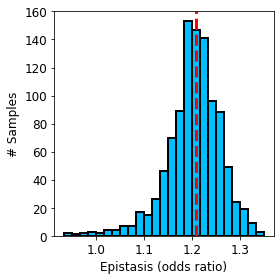

Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
epi_scores.shape = (1410,)
epi_scores_null.shape = (1410,)
wilcoxon p = 6.681584698462358e-205


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


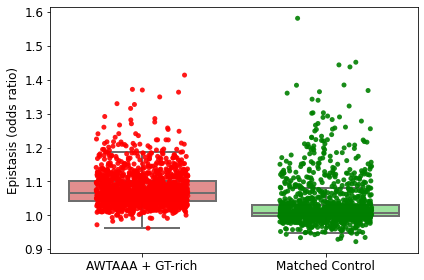

In [92]:
#Analyze epistatic interaction (AWTAAA + GT-rich) in RBBP6

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_RBBP6_AWTAAA_GT_rich'

nts = ['C', 'G', 'T']

region_1_replacements = [
    "".join(np.random.choice(nts, size=(9,)).tolist()) + 'TATAAA' + "".join(np.random.choice(nts, size=(7,)).tolist()) for _ in range(10)
] + [
    "".join(np.random.choice(nts, size=(9,)).tolist()) + 'GATAAA' + "".join(np.random.choice(nts, size=(7,)).tolist()) for _ in range(10)
] + [
    "".join(np.random.choice(nts, size=(9,)).tolist()) + 'CATAAA' + "".join(np.random.choice(nts, size=(7,)).tolist()) for _ in range(10)
] + [
    "".join(np.random.choice(nts, size=(9,)).tolist()) + 'AGTAAA' + "".join(np.random.choice(nts, size=(7,)).tolist()) for _ in range(10)
]

#Single example
_analyze_epistatics(i=109, n_samples=1024, cell_type_1_ix=0, cell_type_2_ix=7, score_ix=2, region_1=[[61, 83]], region_2=[[93, 110]], region_1_replacements=region_1_replacements, epi_sign=-1., save_figs=save_figs, fig_name=fig_name)

#All motif hits
subset_index = np.nonzero(((np.sum(pwm_match_mask[:, 60:80, 0], axis=-1) >= 10. - 1.) & (np.sum(pwm_match_mask_other[:, 80:, 0], axis=-1) >= 10. - 1.)))[0].tolist()
_valid_null_pos_func = lambda i, start_1, start_2, pattern_width, pwm_match_mask, pwm_match_mask_other: [j for j in range(70, 146 - pattern_width) if np.sum(pwm_match_mask_other[i, j:j+pattern_width, 0]) <= 0.]

region_1_replacements = [
    "".join(np.random.choice(nts, size=(2,)).tolist()) + 'TATAAA' + "".join(np.random.choice(nts, size=(2,)).tolist()) for _ in range(10)
] + [
    "".join(np.random.choice(nts, size=(2,)).tolist()) + 'GATAAA' + "".join(np.random.choice(nts, size=(2,)).tolist()) for _ in range(10)
] + [
    "".join(np.random.choice(nts, size=(2,)).tolist()) + 'CATAAA' + "".join(np.random.choice(nts, size=(2,)).tolist()) for _ in range(10)
] + [
    "".join(np.random.choice(nts, size=(2,)).tolist()) + 'AGTAAA' + "".join(np.random.choice(nts, size=(2,)).tolist()) for _ in range(10)
]

_analyze_epistatics_many_heterotypic(subset_index, pwm_match_mask, pwm_match_mask_other, pwm_match_index, pwm_match_index_other, pwm_match_poses, pwm_match_poses_other, region_1_replacements=region_1_replacements, cell_type_1_ix=0, cell_type_2_ix=7, score_ix=2, n_samples=32, _valid_null_pos_func=_valid_null_pos_func, start_1_pos_constraint=74, start_2_pos_constraint=76, epi_sign=-1., hypo_str="AWTAAA + GT-rich", save_figs=save_figs, fig_name=fig_name)


In [20]:
#Find sequences without wildtype GT-rich downstream motifs and a weak CSE

n_wt = 128

df['n_gt'] = df['seq'].str.slice(81, 121).str.count("GTG|TGT|GTCT|TGTC|TGTTGT|GTTT|TTTT|TTAT|GTTT|TTTG")
df['weak_cse'] = df['seq'].str.slice(70, 76).str.contains("ATTAAA|AGTAAA|ACTAAA|TATAAA|GATAAA|CATAAA")
df['use_cse'] = df['seq'].str.slice(0, 73).str.contains("AATAAA|ATTAAA")

wt_index = np.nonzero((((df['n_gt'] == 0) & (df['weak_cse'] == 1)) & (df['use_cse'] == 0)).values)[0][:n_wt]

seqs_wt = df.iloc[wt_index]['seq'].values.tolist()

print("len(seqs_wt) = " + str(len(seqs_wt)))

sim_seqs = [
    seqs_wt,
]

sim_motifs = [
    ["AATAATAAATAA", "TTGTGTGTT"],
]

sim_pos_funcs = [
    [lambda motif_1_len: [67], lambda motif_2_len: (np.arange(149-79) + 79).tolist()],
]

sim_names = [
    "(wt) Weak CSE",
]


len(seqs_wt) = 128


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


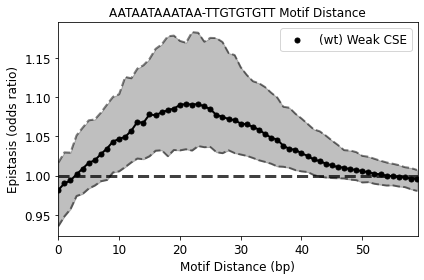

In [22]:
#AWTAAA + GT-rich analysis: uniform WT sample, weak CSE, no T/GT-rich elements in DSE

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_RBBP6_AWTAAA_GT_rich'

load_from_cache = True
cache_name = 'apa_perturb_covar_awtaaa_gt_insertion_epi_scores'

hypo_names = [
    "AATAATAAATAA-TTGTGTGTT Motif Distance",
]

sim_indexes = [
    [0],
]

sim_color_maps = [
    ['black'],
]

x_ranges = [
    [0, 60],
]

plot_areas = [
    True,
]

fig_names = [
    fig_name + "_unif_wt_AWTAAA_GT_rich",
]

_run_insertional_motif_simulation(sim_seqs, sim_motifs, sim_pos_funcs, sim_names, cell_type_1_ix=0, cell_type_2_ix=7, score_ix=2, load_from_cache=load_from_cache, cache_name=cache_name, hypo_names=hypo_names, sim_indexes=sim_indexes, sim_color_maps=sim_color_maps, x_ranges=x_ranges, plot_areas=plot_areas, epi_sign=-1., fig_names=fig_names, save_figs=save_figs)


Processing features for PAS 0...
Processing features for PAS 1...
Processing features for PAS 2...
Processing features for PAS 3...
Processing features for PAS 4...
Processing features for PAS 5...
Processing features for PAS 6...
Processing features for PAS 7...
Processing features for PAS 8...
Processing features for PAS 9...
Done.
x_feat.shape = (5267, 10, 5)

y_lor_kept.shape = (5210,)
x_feat_train.shape = (4710, 10)
x_feat_test.shape = (500, 10)
y_lor_train.shape = (4710,)
y_lor_test.shape = (500,)

[5164. 5317. 1766.  377.   37.]
[3723. 3577. 1409.  438.   66.]
Bootstrap = 0
Bootstrap = 500
(train) r = 0.117
 (test) r = 0.088
   (cv) r = 0.096


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


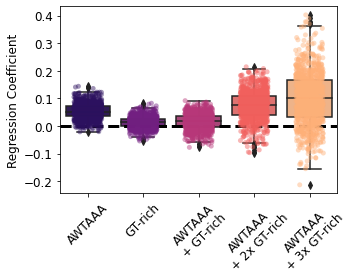

In [38]:
#Linear Model: AWTAAA + GT-rich interaction

#Make polynomial regression features for data (AWTAAA + GT-rich)

import regex as re

#Re-load dataframe
df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

motifs_1 = [
    re.compile(r'(AATAAA)|((AT)|(AA)|(TA))+(C)?(ATTAAA)((AT)|(AA)|(TA))+'),
]
motif_names_1 = [
    'AWTAAA'
]

motifs_2 = [
    re.compile(r'(T[GC]T[GC]T)|([GC]TTT[GC]T)|(T[GC]TTT[GC])|(T[G]TT[GC]T)'),#
]
motif_names_2 = [
    'GTGT',
]

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_RBBP6_AWTAAA_and_GT_rich'

cell_type_1_ix = 0
cell_type_2_ix = 7

nth_order = 3

motif_1_region = [65, 81]
motif_2_region = [81, 121]

x_feats = []
x_feat_str = []
for k in range(m.shape[1]) :
    
    print("Processing features for PAS " + str(k) + "...")
    
    df.loc[df['pas_exists_' + str(k)] == 0, 'wide_seq_ext_' + str(k)] = 'X' * 356
    
    x_feats_k = []
    
    #Single motif 1 counts
    for motif_ix, motif in enumerate(motifs_1) :
        
        df[motif_names_1[motif_ix] + "_" + str(k)] = df['wide_seq_ext_' + str(k)].str.slice(105+motif_1_region[0], 105+motif_1_region[1]).apply(lambda x: 1 if re.search(motif, x) else 0)
        
        x_feats_k.append(df[motif_names_1[motif_ix] + "_" + str(k)].values[:, None, None])
        
        if k == 0 :
            x_feat_str.append(motif_names_1[motif_ix])
    
    #Single motif 2 counts
    for motif_ix, motif in enumerate(motifs_2) :
        
        df[motif_names_2[motif_ix] + "_" + str(k)] = df['wide_seq_ext_' + str(k)].str.slice(105+motif_2_region[0], 105+motif_2_region[1]).apply(lambda x: len(re.findall(motif, x)))
        
        x_feats_k.append(df[motif_names_2[motif_ix] + "_" + str(k)].values[:, None, None])
        
        if k == 0 :
            x_feat_str.append(motif_names_2[motif_ix])
    
    #Combinatorial model indicators
    for motif_1_ix, motif_1 in enumerate(motifs_1) :
        for motif_2_ix, motif_2 in enumerate(motifs_2) :
            for orde in range(1, nth_order+1) :
        
                df[motif_names_1[motif_1_ix] + "_" + motif_names_2[motif_2_ix] + "_" + str(orde) + "_" + str(k)] = df.apply(lambda row: 1 if row[motif_names_1[motif_1_ix] + "_" + str(k)] == 1 and row[motif_names_2[motif_2_ix] + "_" + str(k)] == orde else 0, axis=1)

                x_feats_k.append(df[motif_names_1[motif_1_ix] + "_" + motif_names_2[motif_2_ix] + "_" + str(orde) + "_" + str(k)].values[:, None, None])

                if k == 0 :
                    x_feat_str.append(motif_names_1[motif_1_ix] + "_" + motif_names_2[motif_2_ix] + "_" + str(orde))

    x_feats.append(np.concatenate(x_feats_k, axis=2))

x_feat = np.concatenate(x_feats, axis=1)

print("Done.")

print("x_feat.shape = " + str(x_feat.shape))
print("")

#Run regression and get coefficients
cell_type_1_ix_global = cell_type_dict[subset_cell_types[cell_type_1_ix]]
cell_type_2_ix_global = cell_type_dict[subset_cell_types[cell_type_2_ix]]

keep_index = np.nonzero((np.max(np.sum(x_feat[..., len(motifs_1):len(motifs_1)+len(motifs_2)], axis=-1), axis=-1) <= nth_order) & (((y_dist[:, cell_type_1_ix_global] > 0.) & (y_dist[:, cell_type_1_ix_global] < 1.)) & ((y_dist[:, cell_type_2_ix_global] > 0.) & (y_dist[:, cell_type_2_ix_global] < 1.))))[0]

coefs = _perform_regression(x_feat, motifs, nth_order, keep_index, cell_type_1_ix=cell_type_1_ix, cell_type_2_ix=cell_type_2_ix, n_test=500)

#Analyze regression coefficients (Distal only)

import seaborn as sns
from scipy.stats import ranksums

n_f = x_feat.shape[-1]

w_dist = -coefs[:, 1*n_f:2*n_f]

w_dist_d1 = w_dist[:, :len(motifs_1)]
w_dist_d2 = w_dist[:, len(motifs_1):len(motifs_1)+len(motifs_2)]
w_dist_dd = w_dist[:, len(motifs_1)+len(motifs_2):]

f = plt.figure(figsize=(5, 4))

sns.stripplot(data=[
    w_dist_d1[:, 0],
    w_dist_d2[:, 0],
    w_dist_dd[:, 0],
    w_dist_dd[:, 1],
    w_dist_dd[:, 2],
], alpha=0.45, jitter=0.25, palette='magma')

sns.boxplot(data=[
    w_dist_d1[:, 0],
    w_dist_d2[:, 0],
    w_dist_dd[:, 0],
    w_dist_dd[:, 1],
    w_dist_dd[:, 2],
], palette='magma')

plt.axhline(y=0., color='black', linestyle='--', linewidth=3)

plt.xticks(np.arange(5).tolist(), [
    "AWTAAA",
    "GT-rich",
    "AWTAAA\n+ GT-rich",
    "AWTAAA\n+ 2x GT-rich",
    "AWTAAA\n+ 3x GT-rich",
], fontsize=12, rotation=45)

plt.yticks(fontsize=12)

plt.ylabel("Regression Coefficient", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_regression_coef_dist_only.png", transparent=True, dpi=600)
    plt.savefig(fig_name + "_regression_coef_dist_only.eps")

plt.show()


Processing features for PAS 0...
Processing features for PAS 1...
Processing features for PAS 2...
Processing features for PAS 3...
Processing features for PAS 4...
Processing features for PAS 5...
Processing features for PAS 6...
Processing features for PAS 7...
Processing features for PAS 8...
Processing features for PAS 9...
Done.
x_feat.shape = (5267, 10, 9)

y_lor_kept.shape = (4180,)
x_feat_train.shape = (3680, 18)
x_feat_test.shape = (500, 18)
y_lor_train.shape = (3680,)
y_lor_test.shape = (500,)

[4036. 1345. 1683. 1303. 1085.  727.  828.  677.  614.]
[3003.  862. 1202.  816.  621.  589.  852.  581.  450.]
Bootstrap = 0
Bootstrap = 500
(train) r = 0.115
 (test) r = 0.069
   (cv) r = 0.072


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


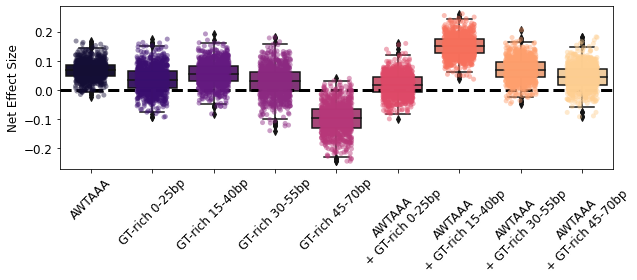

In [43]:
#Linear Model: AWTAAA + GT-rich interaction (by position)

#Make polynomial positional regression features for data (AWTAAA + GT-rich)

import regex as re

#Re-load dataframe
df = pd.read_csv('polyadb_features_pas_3_utr3_perturb.csv', sep='\t')

motifs_1 = [
    re.compile(r'(AATAAA)|((AT)|(AA)|(TA))+(C)?(ATTAAA)((AT)|(AA)|(TA))+'),
]
motif_names_1 = [
    'AWTAAA'
]

motifs_2 = [
    re.compile(r'(T[GC]T[GC]T)|(T[GC]TTT[GC]T)|(T[G]TT[GC]T)'),#
]
motif_names_2 = [
    'GTGT',
]

save_figs = True
fig_name='apa_perturb_10_figures/apa_perturb_RBBP6_AWTAAA_and_positional_GT_rich'

cell_type_1_ix = 0
cell_type_2_ix = 7

nth_order = 1

motif_1_region = [65, 81]
motif_2_region = [79, 149]

motif_2_dist = 25
motif_2_overlap = 10

x_feats = []
x_feat_str = []
for k in range(m.shape[1]) :
    
    print("Processing features for PAS " + str(k) + "...")
    
    df.loc[df['pas_exists_' + str(k)] == 0, 'wide_seq_ext_' + str(k)] = 'X' * 356
    
    x_feats_k = []
    
    #Single motif 1 counts
    for motif_ix, motif in enumerate(motifs_1) :
        
        df[motif_names_1[motif_ix] + "_" + str(k)] = df['wide_seq_ext_' + str(k)].str.slice(105+motif_1_region[0], 105+motif_1_region[1]).apply(lambda x: 1 if re.search(motif, x) else 0)
        
        x_feats_k.append(df[motif_names_1[motif_ix] + "_" + str(k)].values[:, None, None])
        
        if k == 0 :
            x_feat_str.append(motif_names_1[motif_ix])
    
    #Single motif 2 counts
    for motif_ix, motif in enumerate(motifs_2) :
        
        for start_pos in range(motif_2_region[0], motif_2_region[1] - motif_2_dist + 1, motif_2_dist - motif_2_overlap) :
            end_pos = start_pos + motif_2_dist
        
            df[motif_names_2[motif_ix] + "_" + str(start_pos) + "_" + str(end_pos) + "_" + str(k)] = df['wide_seq_ext_' + str(k)].str.slice(105+start_pos, 105+end_pos).apply(lambda x: len(re.findall(motif, x)))

            x_feats_k.append(df[motif_names_2[motif_ix] + "_" + str(start_pos) + "_" + str(end_pos) + "_" + str(k)].values[:, None, None])

            if k == 0 :
                x_feat_str.append(motif_names_2[motif_ix] + "_" + str(start_pos) + "_" + str(end_pos))
    
    #Combinatorial model indicators
    for motif_1_ix, motif_1 in enumerate(motifs_1) :
        for motif_2_ix, motif_2 in enumerate(motifs_2) :
            
            for start_pos in range(motif_2_region[0], motif_2_region[1] - motif_2_dist + 1, motif_2_dist - motif_2_overlap) :
                end_pos = start_pos + motif_2_dist

                for orde in range(1, nth_order+1) :

                    df[motif_names_1[motif_1_ix] + "_" + motif_names_2[motif_2_ix] + "_" + str(start_pos) + "_" + str(end_pos) + "_" + str(orde) + "_" + str(k)] = df.apply(lambda row: 1 if row[motif_names_1[motif_1_ix] + "_" + str(k)] == 1 and row[motif_names_2[motif_2_ix] + "_" + str(start_pos) + "_" + str(end_pos) + "_" + str(k)] == orde else 0, axis=1)

                    x_feats_k.append(df[motif_names_1[motif_1_ix] + "_" + motif_names_2[motif_2_ix] + "_" + str(start_pos) + "_" + str(end_pos) + "_" + str(orde) + "_" + str(k)].values[:, None, None])

                    if k == 0 :
                        x_feat_str.append(motif_names_1[motif_1_ix] + "_" + motif_names_2[motif_2_ix] + "_" + str(start_pos) + "_" + str(end_pos) + "_" + str(orde))

    x_feats.append(np.concatenate(x_feats_k, axis=2))

x_feat = np.concatenate(x_feats, axis=1)

print("Done.")

print("x_feat.shape = " + str(x_feat.shape))
print("")

#Run regression and get coefficients
cell_type_1_ix_global = cell_type_dict[subset_cell_types[cell_type_1_ix]]
cell_type_2_ix_global = cell_type_dict[subset_cell_types[cell_type_2_ix]]

n_distance_bins = 4
keep_index = np.nonzero((np.max(np.max(x_feat[..., len(motifs_1):len(motifs_1)+len(motifs_2)*n_distance_bins], axis=-1), axis=-1) <= nth_order) & (((y_dist[:, cell_type_1_ix_global] > 0.) & (y_dist[:, cell_type_1_ix_global] < 1.)) & ((y_dist[:, cell_type_2_ix_global] > 0.) & (y_dist[:, cell_type_2_ix_global] < 1.))))[0]

coefs = _perform_regression(x_feat, motifs, nth_order, keep_index, cell_type_1_ix=cell_type_1_ix, cell_type_2_ix=cell_type_2_ix, n_test=500)

#Analyze regression coefficients (Distal only)

import seaborn as sns
from scipy.stats import ranksums

n_f = x_feat.shape[-1]

w_dist = -coefs[:, 1*n_f:2*n_f]

w_dist_d1 = w_dist[:, :len(motifs_1)]
w_dist_d2 = w_dist[:, len(motifs_1):len(motifs_1)+len(motifs_2)*n_distance_bins]
w_dist_dd = w_dist[:, len(motifs_1)+len(motifs_2)*n_distance_bins:]

f = plt.figure(figsize=(9, 4))

sns.stripplot(data=[
    w_dist_d1[:, 0],
    w_dist_d2[:, 0],
    w_dist_d2[:, 1],
    w_dist_d2[:, 2],
    w_dist_d2[:, 3],
    w_dist_d1[:, 0] + w_dist_d2[:, 0] + w_dist_dd[:, 0],
    w_dist_d1[:, 0] + w_dist_d2[:, 1] + w_dist_dd[:, 1],
    w_dist_d1[:, 0] + w_dist_d2[:, 2] + w_dist_dd[:, 2],
    w_dist_d1[:, 0] + w_dist_d2[:, 3] + w_dist_dd[:, 3],
], alpha=0.45, jitter=0.25, palette='magma')

sns.boxplot(data=[
    w_dist_d1[:, 0],
    w_dist_d2[:, 0],
    w_dist_d2[:, 1],
    w_dist_d2[:, 2],
    w_dist_d2[:, 3],
    w_dist_d1[:, 0] + w_dist_d2[:, 0] + w_dist_dd[:, 0],
    w_dist_d1[:, 0] + w_dist_d2[:, 1] + w_dist_dd[:, 1],
    w_dist_d1[:, 0] + w_dist_d2[:, 2] + w_dist_dd[:, 2],
    w_dist_d1[:, 0] + w_dist_d2[:, 3] + w_dist_dd[:, 3],
], palette='magma')

plt.axhline(y=0., color='black', linestyle='--', linewidth=3)

plt.xticks(np.arange(9).tolist(), [
    "AWTAAA",
    "GT-rich 0-25bp",
    "GT-rich 15-40bp",
    "GT-rich 30-55bp",
    "GT-rich 45-70bp",
    "AWTAAA\n+ GT-rich 0-25bp",
    "AWTAAA\n+ GT-rich 15-40bp",
    "AWTAAA\n+ GT-rich 30-55bp",
    "AWTAAA\n+ GT-rich 45-70bp",
], fontsize=12, rotation=45)

plt.yticks(fontsize=12)

plt.ylabel("Net Effect Size", fontsize=12)

plt.tight_layout()

if save_figs :
    plt.savefig(fig_name + "_regression_coef_dist_only.png", transparent=True, dpi=600)
    plt.savefig(fig_name + "_regression_coef_dist_only.eps")

plt.show()
